<a href="https://colab.research.google.com/github/SBGuillermo/TFM-AnalisisComercio/blob/main/Notebooks/5_Unsupervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentación de clientes usando métodos de Unsupervised_learning


En este notebooks desarrollaremos diversos modélos de aprendizaje no supervisado para intertar clasificar a nuestros clientes en diferentes grupos con características similares.
Con este sistema podremos entender mejor como actua el conjunto de nuestros clientes y desarrollar acciones más eficientes

En este caso particular, intentaremos generar cluster de clientes teneiendo en cuenta sus gastos y la compra de los 25 objetos más populares de la tienda

Descargaremos el dataset que esta dividido en dos partes, para posteriormente concatanarlo y trabajar sobre él.

In [1]:
# Primero debemos descargar las librerias que sabemos que vamos a utulizar, aunque posteriormente descargaremos otras.
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Descargamos el dataset desde la plataforma github
!wget https://raw.githubusercontent.com/SBGuillermo/TFM-AnalisisComercio/main/DataSet/DataClean/Table1.csv

--2021-07-08 14:17:49--  https://raw.githubusercontent.com/SBGuillermo/TFM-AnalisisComercio/main/DataSet/DataClean/Table1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17889332 (17M) [text/plain]
Saving to: ‘Table1.csv’

Table1.csv          100%[===================>]  17.06M  55.4MB/s    in 0.3s    

2021-07-08 14:17:53 (55.4 MB/s) - ‘Table1.csv’ saved [17889332/17889332]



In [3]:
!wget https://raw.githubusercontent.com/SBGuillermo/TFM-AnalisisComercio/main/DataSet/DataClean/Table2.csv

--2021-07-08 14:17:53--  https://raw.githubusercontent.com/SBGuillermo/TFM-AnalisisComercio/main/DataSet/DataClean/Table2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17784301 (17M) [text/plain]
Saving to: ‘Table2.csv’

Table2.csv          100%[===================>]  16.96M   110MB/s    in 0.2s    

2021-07-08 14:17:54 (110 MB/s) - ‘Table2.csv’ saved [17784301/17784301]



In [4]:
#Es necesario convertir los dos dataset en Pandas DataFrame para poder trabajar sobre ellos
df1 = pd.read_csv('/content/Table1.csv')
df1

,Unnamed: 0,Unnamed: 0.1,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,PrecioTotal
0,0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,1,1,536365,71053,other,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,2,2,536365,84406B,other,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,3,3,536365,84029G,other,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,4,4,536365,84029E,other,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...,...,...
199995,199995,285947,561967,22400,other,3,2011-08-01 13:11:00,0.39,12844.0,United Kingdom,1.17
199996,199996,285948,561967,82482,WOODEN PICTURE FRAME WHITE FINISH,5,2011-08-01 13:11:00,2.55,12844.0,United Kingdom,12.75
199997,199997,285949,561967,82551,other,3,2011-08-01 13:11:00,1.45,12844.0,United Kingdom,4.35
199998,199998,285950,561967,82552,other,3,2011-08-01 13:11:00,1.45,12844.0,United Kingdom,4.35


In [5]:
df2 = pd.read_csv('/content/Table2.csv')
df2

,Unnamed: 0,Unnamed: 0.1,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,PrecioTotal
0,200000,285952,561967,23306,other,3,2011-08-01 13:11:00,1.45,12844.0,United Kingdom,4.35
1,200001,285953,561967,47504H,other,1,2011-08-01 13:11:00,0.79,12844.0,United Kingdom,0.79
2,200002,285954,561967,21907,other,6,2011-08-01 13:11:00,2.10,12844.0,United Kingdom,12.60
3,200003,285955,561967,21992,other,3,2011-08-01 13:11:00,1.25,12844.0,United Kingdom,3.75
4,200004,285956,561967,21754,other,2,2011-08-01 13:11:00,5.95,12844.0,United Kingdom,11.90
...,...,...,...,...,...,...,...,...,...,...,...
197919,397919,541904,581587,22613,other,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
197920,397920,541905,581587,22899,other,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
197921,397921,541906,581587,23254,other,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
197922,397922,541907,581587,23255,other,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [6]:
# Concatenamos nuestos dos Dataframe para conseguir el dataset completo 
df = pd.concat([df1,df2], axis=0)
df

,Unnamed: 0,Unnamed: 0.1,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,PrecioTotal
0,0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,1,1,536365,71053,other,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,2,2,536365,84406B,other,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,3,3,536365,84029G,other,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,4,4,536365,84029E,other,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...,...,...
197919,397919,541904,581587,22613,other,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
197920,397920,541905,581587,22899,other,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
197921,397921,541906,581587,23254,other,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
197922,397922,541907,581587,23255,other,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [7]:
#borramos las columnas erroneas que no pertenecen al data set inicial
df = df.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1)

In [8]:
df = df.reset_index(drop=True)

Se puede observar en la tabla anterior que exiten un objeto 'other' en la columna 'Descrition'. Esto se debe a que se decidio utilizar solo los 25 objetos a la venta más populares de la tienda. Para más información ver el Notebooks 1_AnalisisComercio_Cleanup

Para evitar que el objeto 'other' desvirtue los datos al final al tener mucho más peso que los demás, lo eliminaremos

In [9]:
df = df.copy().drop(df.loc[df['Description']=='other'].index)
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,PrecioTotal
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,54.08
21,536368,22960,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,13047.0,United Kingdom,25.50
27,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583.0,France,90.00
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583.0,France,54.00
...,...,...,...,...,...,...,...,...,...
397837,581579,22993,SET OF 4 PANTRY JELLY MOULDS,12,2011-12-09 12:19:00,1.25,17581.0,United Kingdom,15.00
397880,581583,20725,LUNCH BAG RED RETROSPOT,40,2011-12-09 12:23:00,1.45,13777.0,United Kingdom,58.00
397890,581585,84879,ASSORTED COLOUR BIRD ORNAMENT,16,2011-12-09 12:31:00,1.69,15804.0,United Kingdom,27.04
397895,581585,22727,ALARM CLOCK BAKELIKE RED,4,2011-12-09 12:31:00,3.75,15804.0,United Kingdom,15.00


##KMeans

El primer método a utilizar va a ser el de KMeans.

Es un método computacionalmente muy sencillo y que tiene una gran versatilidad, pudiéndose ser utilizado en prácticamente cualquier conjunto de datos. Por eso será nuestra primera opción.

Los dos mayores inconvenientes de este método son:
  - Hay que elegir los clusteres antes de llevarlo a cabo

  - No es un método estable, al repetir el proceso te pueden dar resultados diferentes

### One Hot Encoder

Aunque idealmente se podría crear un pipeline que me llevara todos los diferentes procesos de transformación, incluido en OneHotEncode, a la vez, esto no va a ser posible por el tipo de datos que tenemos.

Al estar los datos separados por los distintos objetos de compra y no por cada compra o cliente, nos será necesario agrupar multiples veces los datos despúes de llevar a cabo nuesto OneHotEncoder

In [10]:
#Llevamos a cabo la operación OneHotEncoder con la colunma description (objetos a la venta)
encoder = OneHotEncoder()

encoded = encoder.fit_transform(df['Description'].dropna().values.reshape(-1, 1))

encoded.todense()

matrix([[0., 0., 0., ..., 0., 1., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]])

In [11]:
result_encoding = pd.DataFrame(encoded.todense(), index = df['Description'].dropna().index, columns = encoder.categories_)

In [12]:
result_encoding

,ALARM CLOCK BAKELIKE RED,ASSORTED COLOUR BIRD ORNAMENT,HEART OF WICKER SMALL,JAM MAKING SET WITH JARS,JUMBO BAG PINK POLKADOT,JUMBO BAG RED RETROSPOT,LUNCH BAG BLACK SKULL.,LUNCH BAG APPLE DESIGN,LUNCH BAG CARS BLUE,LUNCH BAG PINK POLKADOT,LUNCH BAG RED RETROSPOT,LUNCH BAG SPACEBOY DESIGN,LUNCH BAG SUKI DESIGN,NATURAL SLATE HEART CHALKBOARD,PACK OF 72 RETROSPOT CAKE CASES,PAPER CHAIN KIT 50'S CHRISTMAS,PARTY BUNTING,POSTAGE,REGENCY CAKESTAND 3 TIER,REX CASH+CARRY JUMBO SHOPPER,SET OF 3 CAKE TINS PANTRY DESIGN,SET OF 4 PANTRY JELLY MOULDS,SPOTTY BUNTING,WHITE HANGING HEART T-LIGHT HOLDER,WOODEN PICTURE FRAME WHITE FINISH
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
397880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397890,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397895,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Durante el proceso se han modificado los nombres de las columnas, por lo que las rescribiremos, este es un proceso puramente estético para mejorar la legibilidad del DataFrame

In [13]:
#la tranformación ha añadido parentesis a los nombres de las columnas
result_encoding.columns

MultiIndex([(          'ALARM CLOCK BAKELIKE RED',),
            (     'ASSORTED COLOUR BIRD ORNAMENT',),
            (             'HEART OF WICKER SMALL',),
            (          'JAM MAKING SET WITH JARS',),
            (           'JUMBO BAG PINK POLKADOT',),
            (           'JUMBO BAG RED RETROSPOT',),
            (           'LUNCH BAG  BLACK SKULL.',),
            (            'LUNCH BAG APPLE DESIGN',),
            (               'LUNCH BAG CARS BLUE',),
            (           'LUNCH BAG PINK POLKADOT',),
            (           'LUNCH BAG RED RETROSPOT',),
            (         'LUNCH BAG SPACEBOY DESIGN',),
            (             'LUNCH BAG SUKI DESIGN',),
            (    'NATURAL SLATE HEART CHALKBOARD',),
            (   'PACK OF 72 RETROSPOT CAKE CASES',),
            (    'PAPER CHAIN KIT 50'S CHRISTMAS',),
            (                     'PARTY BUNTING',),
            (                           'POSTAGE',),
            (          'REGENCY CAKESTAND 3 TI

In [14]:
result_encoding.columns = ['WHITE HANGING HEART T-LIGHT HOLDER', 'REGENCY CAKESTAND 3 TIER',
       'JUMBO BAG RED RETROSPOT', 'ASSORTED COLOUR BIRD ORNAMENT',
       'PARTY BUNTING', 'LUNCH BAG RED RETROSPOT',
       'SET OF 3 CAKE TINS PANTRY DESIGN', 'LUNCH BAG  BLACK SKULL.',
       'JAM MAKING SET PRINTED', 'PACK OF 72 RETROSPOT CAKE CASES',
       "PAPER CHAIN KIT 50'S CHRISTMAS", 'SPOTTY BUNTING',
       'LUNCH BAG SPACEBOY DESIGN', 'LUNCH BAG CARS BLUE',
       'HEART OF WICKER SMALL', 'NATURAL SLATE HEART CHALKBOARD',
       'LUNCH BAG PINK POLKADOT', 'REX CASH+CARRY JUMBO SHOPPER',
       'LUNCH BAG SUKI DESIGN', 'ALARM CLOCK BAKELIKE RED',
       'LUNCH BAG APPLE DESIGN', 'SET OF 4 PANTRY JELLY MOULDS',
       'JUMBO BAG PINK POLKADOT', 'JAM MAKING SET WITH JARS',
       'WOODEN PICTURE FRAME WHITE FINISH']

Debemos concatenar la tabla inicial con la tabla resultante de los elementos a la venta para relacionar cada una de las transacciones con los elementos comprados

In [15]:
Total_data = pd.DataFrame()
Total_data = pd.concat([df, result_encoding], axis=1)
Total_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,PrecioTotal,WHITE HANGING HEART T-LIGHT HOLDER,REGENCY CAKESTAND 3 TIER,JUMBO BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,PARTY BUNTING,LUNCH BAG RED RETROSPOT,SET OF 3 CAKE TINS PANTRY DESIGN,LUNCH BAG BLACK SKULL.,JAM MAKING SET PRINTED,PACK OF 72 RETROSPOT CAKE CASES,PAPER CHAIN KIT 50'S CHRISTMAS,SPOTTY BUNTING,LUNCH BAG SPACEBOY DESIGN,LUNCH BAG CARS BLUE,HEART OF WICKER SMALL,NATURAL SLATE HEART CHALKBOARD,LUNCH BAG PINK POLKADOT,REX CASH+CARRY JUMBO SHOPPER,LUNCH BAG SUKI DESIGN,ALARM CLOCK BAKELIKE RED,LUNCH BAG APPLE DESIGN,SET OF 4 PANTRY JELLY MOULDS,JUMBO BAG PINK POLKADOT,JAM MAKING SET WITH JARS,WOODEN PICTURE FRAME WHITE FINISH
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,54.08,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,536368,22960,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,13047.0,United Kingdom,25.50,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583.0,France,90.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583.0,France,54.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397837,581579,22993,SET OF 4 PANTRY JELLY MOULDS,12,2011-12-09 12:19:00,1.25,17581.0,United Kingdom,15.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
397880,581583,20725,LUNCH BAG RED RETROSPOT,40,2011-12-09 12:23:00,1.45,13777.0,United Kingdom,58.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397890,581585,84879,ASSORTED COLOUR BIRD ORNAMENT,16,2011-12-09 12:31:00,1.69,15804.0,United Kingdom,27.04,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397895,581585,22727,ALARM CLOCK BAKELIKE RED,4,2011-12-09 12:31:00,3.75,15804.0,United Kingdom,15.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Con esta tabla tenemos todos los datos transformados para poder llevar a cabo las agrupaciones por comprar y clientes.
Para ello eliminaremos las columnas que no nos interesan para el futuro análisis

In [16]:
ToAnalice_data=Total_data.drop(['StockCode','Description','InvoiceDate', 'UnitPrice', 'Country','InvoiceNo'], axis=1)
ToAnalice_data.head()

,Quantity,CustomerID,PrecioTotal,WHITE HANGING HEART T-LIGHT HOLDER,REGENCY CAKESTAND 3 TIER,JUMBO BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,PARTY BUNTING,LUNCH BAG RED RETROSPOT,SET OF 3 CAKE TINS PANTRY DESIGN,LUNCH BAG BLACK SKULL.,JAM MAKING SET PRINTED,PACK OF 72 RETROSPOT CAKE CASES,PAPER CHAIN KIT 50'S CHRISTMAS,SPOTTY BUNTING,LUNCH BAG SPACEBOY DESIGN,LUNCH BAG CARS BLUE,HEART OF WICKER SMALL,NATURAL SLATE HEART CHALKBOARD,LUNCH BAG PINK POLKADOT,REX CASH+CARRY JUMBO SHOPPER,LUNCH BAG SUKI DESIGN,ALARM CLOCK BAKELIKE RED,LUNCH BAG APPLE DESIGN,SET OF 4 PANTRY JELLY MOULDS,JUMBO BAG PINK POLKADOT,JAM MAKING SET WITH JARS,WOODEN PICTURE FRAME WHITE FINISH
0,6,17850.0,15.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,32,13047.0,54.08,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,6,13047.0,25.50,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,24,12583.0,90.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,3,12583.0,54.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


En este punto del proceso podríamos optar por dos opciones.
  - Intentar crear clusters solo con el dinero gastado y los elementos comprados diferentes cogidos individualmente, sin tener en cuenta el número de dichos elementos
  - O intentar generar clusters utilizando tanto el dinero gastado como la cantidad total de elementos comprados.

La segunda opción es la que se llevará a cabo, porque podría darnos una idea más concreta de las características de los clientes, al no peder parte de los datos

Para ello, multiplicaremos todas las columnas creadas en el OneHotEncoder por la columna Quantity, que posteriormete eliminaremos

In [17]:
for x in range (4, len(ToAnalice_data.columns)):
  ToAnalice_data.iloc[:,x] = ToAnalice_data.iloc[:,x] * ToAnalice_data.iloc[:,0]

In [18]:
ToAnalice_data.head()

,Quantity,CustomerID,PrecioTotal,WHITE HANGING HEART T-LIGHT HOLDER,REGENCY CAKESTAND 3 TIER,JUMBO BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,PARTY BUNTING,LUNCH BAG RED RETROSPOT,SET OF 3 CAKE TINS PANTRY DESIGN,LUNCH BAG BLACK SKULL.,JAM MAKING SET PRINTED,PACK OF 72 RETROSPOT CAKE CASES,PAPER CHAIN KIT 50'S CHRISTMAS,SPOTTY BUNTING,LUNCH BAG SPACEBOY DESIGN,LUNCH BAG CARS BLUE,HEART OF WICKER SMALL,NATURAL SLATE HEART CHALKBOARD,LUNCH BAG PINK POLKADOT,REX CASH+CARRY JUMBO SHOPPER,LUNCH BAG SUKI DESIGN,ALARM CLOCK BAKELIKE RED,LUNCH BAG APPLE DESIGN,SET OF 4 PANTRY JELLY MOULDS,JUMBO BAG PINK POLKADOT,JAM MAKING SET WITH JARS,WOODEN PICTURE FRAME WHITE FINISH
0,6,17850.0,15.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0
9,32,13047.0,54.08,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,6,13047.0,25.50,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,24,12583.0,90.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,3,12583.0,54.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
#eliminamos la columna Quantity
ToAnalice_data=ToAnalice_data.drop(['Quantity'], axis=1)

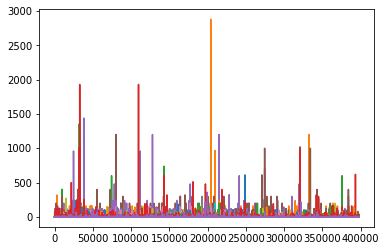

In [20]:
#en esta grafica podemos ver que existen elementos que se compran maxivamente y otros que comprar muy poco.
#Esto habrá que tratarlo posterormente 
Plot_table = ToAnalice_data.drop(['CustomerID','PrecioTotal'], axis=1)
Plot_table.plot(legend= False)

Ahora debemos agrupar los datos según los clientes para obtener la información completa de cada no de esos clientes

In [21]:
#aparte de agrupar los datos debemos sumarlos para obtener los datos finales
Final_data = ToAnalice_data.groupby(['CustomerID'], axis=0).sum()
Final_data.head()

,PrecioTotal,WHITE HANGING HEART T-LIGHT HOLDER,REGENCY CAKESTAND 3 TIER,JUMBO BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,PARTY BUNTING,LUNCH BAG RED RETROSPOT,SET OF 3 CAKE TINS PANTRY DESIGN,LUNCH BAG BLACK SKULL.,JAM MAKING SET PRINTED,PACK OF 72 RETROSPOT CAKE CASES,PAPER CHAIN KIT 50'S CHRISTMAS,SPOTTY BUNTING,LUNCH BAG SPACEBOY DESIGN,LUNCH BAG CARS BLUE,HEART OF WICKER SMALL,NATURAL SLATE HEART CHALKBOARD,LUNCH BAG PINK POLKADOT,REX CASH+CARRY JUMBO SHOPPER,LUNCH BAG SUKI DESIGN,ALARM CLOCK BAKELIKE RED,LUNCH BAG APPLE DESIGN,SET OF 4 PANTRY JELLY MOULDS,JUMBO BAG PINK POLKADOT,JAM MAKING SET WITH JARS,WOODEN PICTURE FRAME WHITE FINISH
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,
12347.0,326.25,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0
12348.0,360.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12349.0,353.10,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0
12350.0,40.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12352.0,403.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,5.0,0.0,6.0,12.0,3.0,0.0,0.0


En la gráfica siguiente podemos ver que exite un grupo reducido de clientes que compra gran cantidas de productos y el resto se mantiene en un nivel medio o bajo

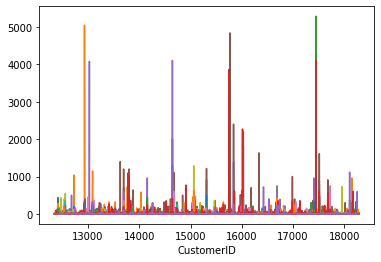

In [22]:
Final_data_plot=Final_data.drop(['PrecioTotal'],axis=1)
Final_data_plot.plot(legend= False)

A continuación vamos a explorar los datos viendo la grafica de cada una de las columnas

In [23]:
col = ['PrecioTotal','WHITE HANGING HEART T-LIGHT HOLDER', 'REGENCY CAKESTAND 3 TIER',
       'JUMBO BAG RED RETROSPOT', 'ASSORTED COLOUR BIRD ORNAMENT',
       'PARTY BUNTING', 'LUNCH BAG RED RETROSPOT',
       'SET OF 3 CAKE TINS PANTRY DESIGN', 'LUNCH BAG  BLACK SKULL.',
       'JAM MAKING SET PRINTED', 'PACK OF 72 RETROSPOT CAKE CASES',
       "PAPER CHAIN KIT 50'S CHRISTMAS", 'SPOTTY BUNTING',
       'LUNCH BAG SPACEBOY DESIGN', 'LUNCH BAG CARS BLUE',
       'HEART OF WICKER SMALL', 'NATURAL SLATE HEART CHALKBOARD',
       'LUNCH BAG PINK POLKADOT', 'REX CASH+CARRY JUMBO SHOPPER',
       'LUNCH BAG SUKI DESIGN', 'ALARM CLOCK BAKELIKE RED',
       'LUNCH BAG APPLE DESIGN', 'SET OF 4 PANTRY JELLY MOULDS',
       'JUMBO BAG PINK POLKADOT', 'JAM MAKING SET WITH JARS',
       'WOODEN PICTURE FRAME WHITE FINISH']

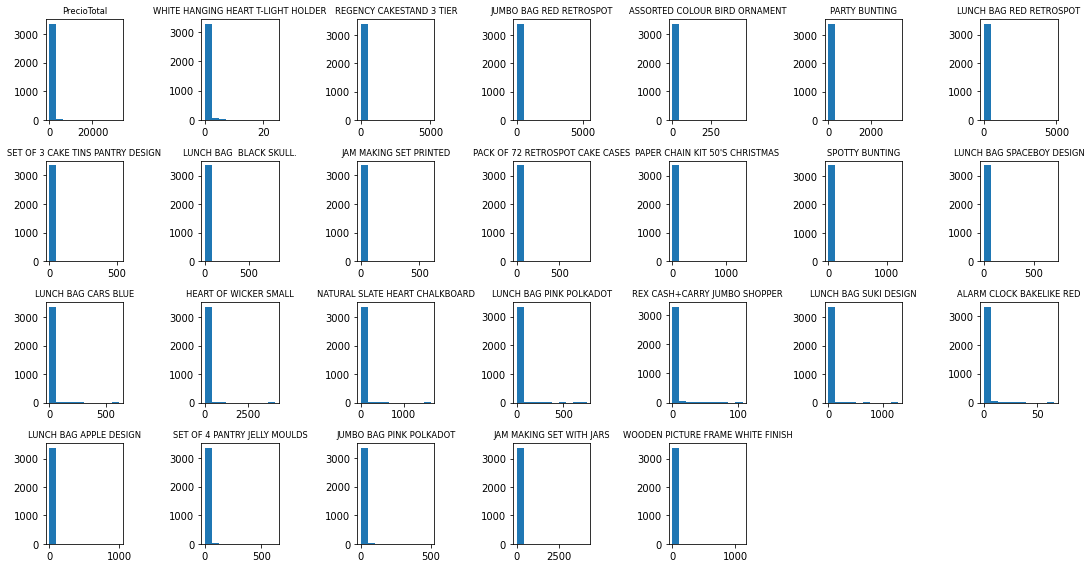

In [24]:
plt.figure(figsize=(15,8))
for i,col in enumerate(Final_data.columns):
  plt.subplot(4,7,i+1)
  plt.title(col, fontsize='small')
  plt.hist(Final_data[col])
plt.tight_layout()

De la grafica anteior se pueden concluir dos cosas:
  - que dentro de una misma categoria, siempre la totalidad o casi la totalidad de los elementos estan muy cerca.
  - que existen gran disparidad entre la cantidad de unos elementos y otros.

## Método KMeans

Vamos a seleccionar 5 valores al azar para comparar posteriormente en que cluster los colocaría el modelo

In [25]:
#para ello utilizamos el método sample que te coge aleatoriamente un número de filas
Test_data = Final_data.sample(5)
Test_data

,PrecioTotal,WHITE HANGING HEART T-LIGHT HOLDER,REGENCY CAKESTAND 3 TIER,JUMBO BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,PARTY BUNTING,LUNCH BAG RED RETROSPOT,SET OF 3 CAKE TINS PANTRY DESIGN,LUNCH BAG BLACK SKULL.,JAM MAKING SET PRINTED,PACK OF 72 RETROSPOT CAKE CASES,PAPER CHAIN KIT 50'S CHRISTMAS,SPOTTY BUNTING,LUNCH BAG SPACEBOY DESIGN,LUNCH BAG CARS BLUE,HEART OF WICKER SMALL,NATURAL SLATE HEART CHALKBOARD,LUNCH BAG PINK POLKADOT,REX CASH+CARRY JUMBO SHOPPER,LUNCH BAG SUKI DESIGN,ALARM CLOCK BAKELIKE RED,LUNCH BAG APPLE DESIGN,SET OF 4 PANTRY JELLY MOULDS,JUMBO BAG PINK POLKADOT,JAM MAKING SET WITH JARS,WOODEN PICTURE FRAME WHITE FINISH
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,
13475.0,141.30,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0
17569.0,54.21,1.0,24.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16464.0,74.49,0.0,0.0,0.0,0.0,2.0,1.0,0.0,2.0,4.0,2.0,2.0,3.0,0.0,0.0,5.0,9.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0
13116.0,35.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0
12515.0,145.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0


El indice del nuevo dataset de test nos servirá para borrar dichos elementos en el dataset total.

No queremos que se repitan los mismos clientes en ambos dataset ya que desvirtuaria el resultado

In [26]:
Test_data.index

Float64Index([13475.0, 17569.0, 16464.0, 13116.0, 12515.0], dtype='float64', name='CustomerID')

In [27]:
#eliminamos el set de test del total
Final_data2= Final_data.drop(Test_data.index, axis=0)
Final_data2

,PrecioTotal,WHITE HANGING HEART T-LIGHT HOLDER,REGENCY CAKESTAND 3 TIER,JUMBO BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,PARTY BUNTING,LUNCH BAG RED RETROSPOT,SET OF 3 CAKE TINS PANTRY DESIGN,LUNCH BAG BLACK SKULL.,JAM MAKING SET PRINTED,PACK OF 72 RETROSPOT CAKE CASES,PAPER CHAIN KIT 50'S CHRISTMAS,SPOTTY BUNTING,LUNCH BAG SPACEBOY DESIGN,LUNCH BAG CARS BLUE,HEART OF WICKER SMALL,NATURAL SLATE HEART CHALKBOARD,LUNCH BAG PINK POLKADOT,REX CASH+CARRY JUMBO SHOPPER,LUNCH BAG SUKI DESIGN,ALARM CLOCK BAKELIKE RED,LUNCH BAG APPLE DESIGN,SET OF 4 PANTRY JELLY MOULDS,JUMBO BAG PINK POLKADOT,JAM MAKING SET WITH JARS,WOODEN PICTURE FRAME WHITE FINISH
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,
12347.0,326.25,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0
12348.0,360.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12349.0,353.10,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0
12350.0,40.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12352.0,403.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,5.0,0.0,6.0,12.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18277.0,13.52,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18278.0,15.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18280.0,15.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Debido a las diferencias notables entre las distintas cantidades de objetos comprados, y sobre todo, entre estas y el precio final, se hace necesario normalizar los datos para igual los pesos de dichas varaibles en el posterior procesado

In [28]:
from sklearn import preprocessing
Normalized_data = preprocessing.Normalizer().fit_transform(Final_data2)
Normalized_data

array([[0.99882768, 0.0153077 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.99968765, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.99981157, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.99778516, 0.06651901, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.99693838, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.98680366, 0.        , 0.        , ..., 0.00279841, 0.02798411,
        0.        ]])

In [29]:
type(Normalized_data)

numpy.ndarray

Para establecer el número de clusters que necesitamos, vamos a desarrollar la función codo

In [30]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer

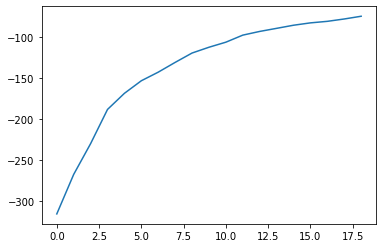

In [31]:
nc = range(1, 20) 
kmeans = [KMeans(n_clusters=i) for i in nc]
score = [kmeans[i].fit(Normalized_data).score(Normalized_data) for i in range(len(kmeans))]

plt.plot(score);

En la gráfica anteior vemos que no exite un codo claro en los datos

Si entrenamos el modelo con estos datos no deberían salir unos clusteres claros.

Elegimos 6 clusters para ver los resultados

In [32]:
#entrenamos el modelo con los datos
kmeans2 = KMeans(n_clusters=6).fit(Normalized_data)

In [33]:
#predicimos a que cluster va a ir cada cliente
Final_data_cluster = Final_data2.copy()
Final_data_cluster["cluster"] = kmeans2.predict(Normalized_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


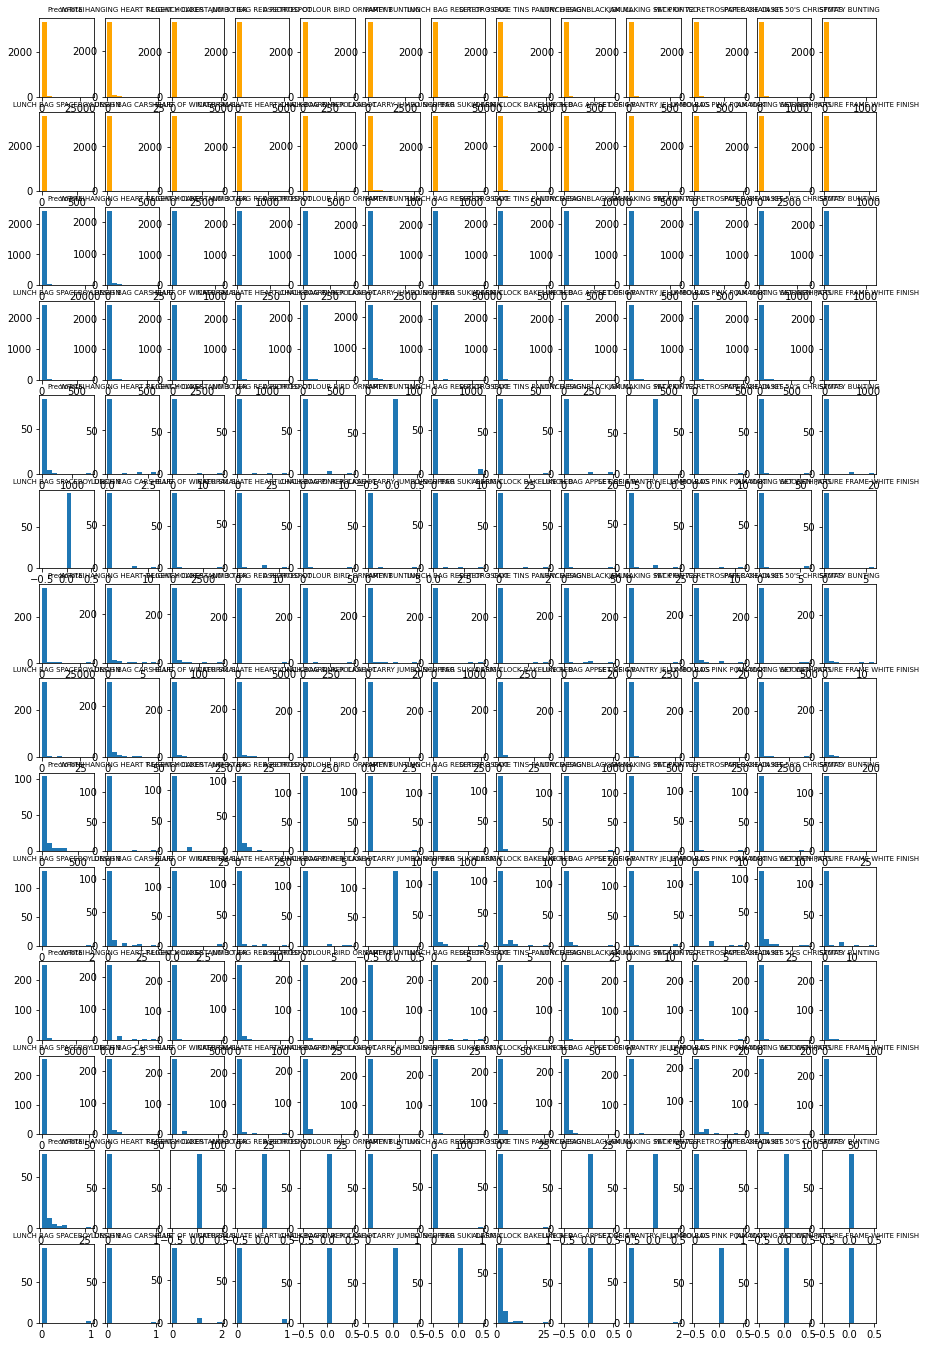

In [34]:
#graficamos los resultados
cols = ['PrecioTotal','WHITE HANGING HEART T-LIGHT HOLDER', 'REGENCY CAKESTAND 3 TIER',
       'JUMBO BAG RED RETROSPOT', 'ASSORTED COLOUR BIRD ORNAMENT',
       'PARTY BUNTING', 'LUNCH BAG RED RETROSPOT',
       'SET OF 3 CAKE TINS PANTRY DESIGN', 'LUNCH BAG  BLACK SKULL.',
       'JAM MAKING SET PRINTED', 'PACK OF 72 RETROSPOT CAKE CASES',
       "PAPER CHAIN KIT 50'S CHRISTMAS", 'SPOTTY BUNTING',
       'LUNCH BAG SPACEBOY DESIGN', 'LUNCH BAG CARS BLUE',
       'HEART OF WICKER SMALL', 'NATURAL SLATE HEART CHALKBOARD',
       'LUNCH BAG PINK POLKADOT', 'REX CASH+CARRY JUMBO SHOPPER',
       'LUNCH BAG SUKI DESIGN', 'ALARM CLOCK BAKELIKE RED',
       'LUNCH BAG APPLE DESIGN', 'SET OF 4 PANTRY JELLY MOULDS',
       'JUMBO BAG PINK POLKADOT', 'JAM MAKING SET WITH JARS',
       'WOODEN PICTURE FRAME WHITE FINISH']
height = len(Final_data_cluster["cluster"].unique())
plt.figure(figsize=(15,4*height))

for i,col in enumerate(cols):
  plt.subplot(2*(1+height),13,i+1)
  plt.title(col, fontsize='x-small')
  plt.hist(Final_data_cluster[col],color="orange")

for j,k in enumerate(Final_data_cluster["cluster"].unique()):
  for i,col in enumerate(cols):
    plt.subplot(2*(1+height),13,(26*(j+1))+i+1)
    plt.title(col, fontsize='x-small')
    plt.hist(Final_data_cluster[Final_data_cluster["cluster"]==k][col])
plt.tight_layout();

Como vemos en la tabla anterior, al normalizar todas las columnas se pierden demasiados datos y nos daria que la practica totalidad de los clientes pertenecerían al mismo cluster

In [35]:
Final_data_cluster["cluster"].value_counts()

0    2472
5     330
2     259
3     130
4      93
1      91
Name: cluster, dtype: int64

Podemos probar a normalizar solo los datos de la columna de PrecioTotal al ser la que más desviada esta, dando más peso en el análisis a los productos más comprados

In [36]:
#creamos un dataframe solo con la columna PrecioTotal
NormalizePrize_data = pd.DataFrame()
NormalizePrize_data['NormalizePrice'] = Final_data2.PrecioTotal
NormalizePrize_data

,NormalizePrice
CustomerID,
12347.0,326.25
12348.0,360.00
12349.0,353.10
12350.0,40.00
12352.0,403.30
...,...
18277.0,13.52
18278.0,15.00
18280.0,15.00


Para normalizar los datos podemos elegir una función basandonos en la media y la deviación estandar o en el minimo y en el máximo

realizamos la prueba con los dos y decidimos quedarnos con la primera opción ya que la segunda lleva a nùmero muy cercanos al 0

In [37]:
#creamos una función que nos permita nomalizar los datos apartir de la media y la desviación estandar
def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

In [38]:
NormalizePrize_data_mean = mean_norm(NormalizePrize_data)
NormalizePrize_data_mean

,NormalizePrice
CustomerID,
12347.0,0.033636
12348.0,0.063441
12349.0,0.057348
12350.0,-0.219154
12352.0,0.101680
...,...
18277.0,-0.242539
18278.0,-0.241232
18280.0,-0.241232


In [39]:
#creamos una función que nos permita nomalizar los datos apartir del máximo y el mínimo
def mean_norm2(df_input):
    return df_input.apply(lambda x: (x-x.min())/ (x.max()-x.min()), axis=0)

In [40]:
mean_norm2(NormalizePrize_data)

,NormalizePrice
CustomerID,
12347.0,0.010050
12348.0,0.011092
12349.0,0.010879
12350.0,0.001217
12352.0,0.012428
...,...
18277.0,0.000400
18278.0,0.000446
18280.0,0.000446


Creamos la tabla con los nuevos datos para pasar a su entrenamiento

In [41]:
NormalizePrize_data_total = pd.concat([NormalizePrize_data_mean,Final_data2], axis= 1)
NormalizePrize_data_total = NormalizePrize_data_total.drop('PrecioTotal', axis=1)
NormalizePrize_data_total.head()

,NormalizePrice,WHITE HANGING HEART T-LIGHT HOLDER,REGENCY CAKESTAND 3 TIER,JUMBO BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,PARTY BUNTING,LUNCH BAG RED RETROSPOT,SET OF 3 CAKE TINS PANTRY DESIGN,LUNCH BAG BLACK SKULL.,JAM MAKING SET PRINTED,PACK OF 72 RETROSPOT CAKE CASES,PAPER CHAIN KIT 50'S CHRISTMAS,SPOTTY BUNTING,LUNCH BAG SPACEBOY DESIGN,LUNCH BAG CARS BLUE,HEART OF WICKER SMALL,NATURAL SLATE HEART CHALKBOARD,LUNCH BAG PINK POLKADOT,REX CASH+CARRY JUMBO SHOPPER,LUNCH BAG SUKI DESIGN,ALARM CLOCK BAKELIKE RED,LUNCH BAG APPLE DESIGN,SET OF 4 PANTRY JELLY MOULDS,JUMBO BAG PINK POLKADOT,JAM MAKING SET WITH JARS,WOODEN PICTURE FRAME WHITE FINISH
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,
12347.0,0.033636,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0
12348.0,0.063441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12349.0,0.057348,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0
12350.0,-0.219154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12352.0,0.101680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,5.0,0.0,6.0,12.0,3.0,0.0,0.0


In [42]:
NormalizePrize_data_total.shape

(3375, 26)

Volviendo a utilizar la función del codo establecemos que 6 es un número de cluster que puede dar buen resultado

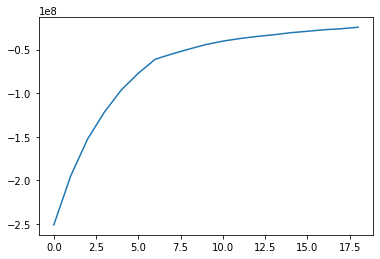

In [43]:
nc = range(1, 20) 
kmeans = [KMeans(n_clusters=i) for i in nc]
score = [kmeans[i].fit(NormalizePrize_data_total).score(NormalizePrize_data_total) for i in range(len(kmeans))]

plt.plot(score);

In [44]:
NormalizePrize_data_total_nmp=NormalizePrize_data_total.to_numpy()
NormalizePrize_data_total_nmp

array([[ 0.03363616,  5.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.06344116,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0573477 ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.24123224,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.23195957,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.05693263,  0.        ,  0.        , ...,  1.        ,
        10.        ,  0.        ]])

Entrenamos el modelo con los nuevos datos y predecimos donde van a estar situados cada cliente

In [95]:
kmeans = KMeans(n_clusters=6).fit(NormalizePrize_data_total)

In [100]:
Final_data_cluster2 = NormalizePrize_data_total.copy()
Final_data_cluster2["cluster"] = kmeans2.predict(NormalizePrize_data_total)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


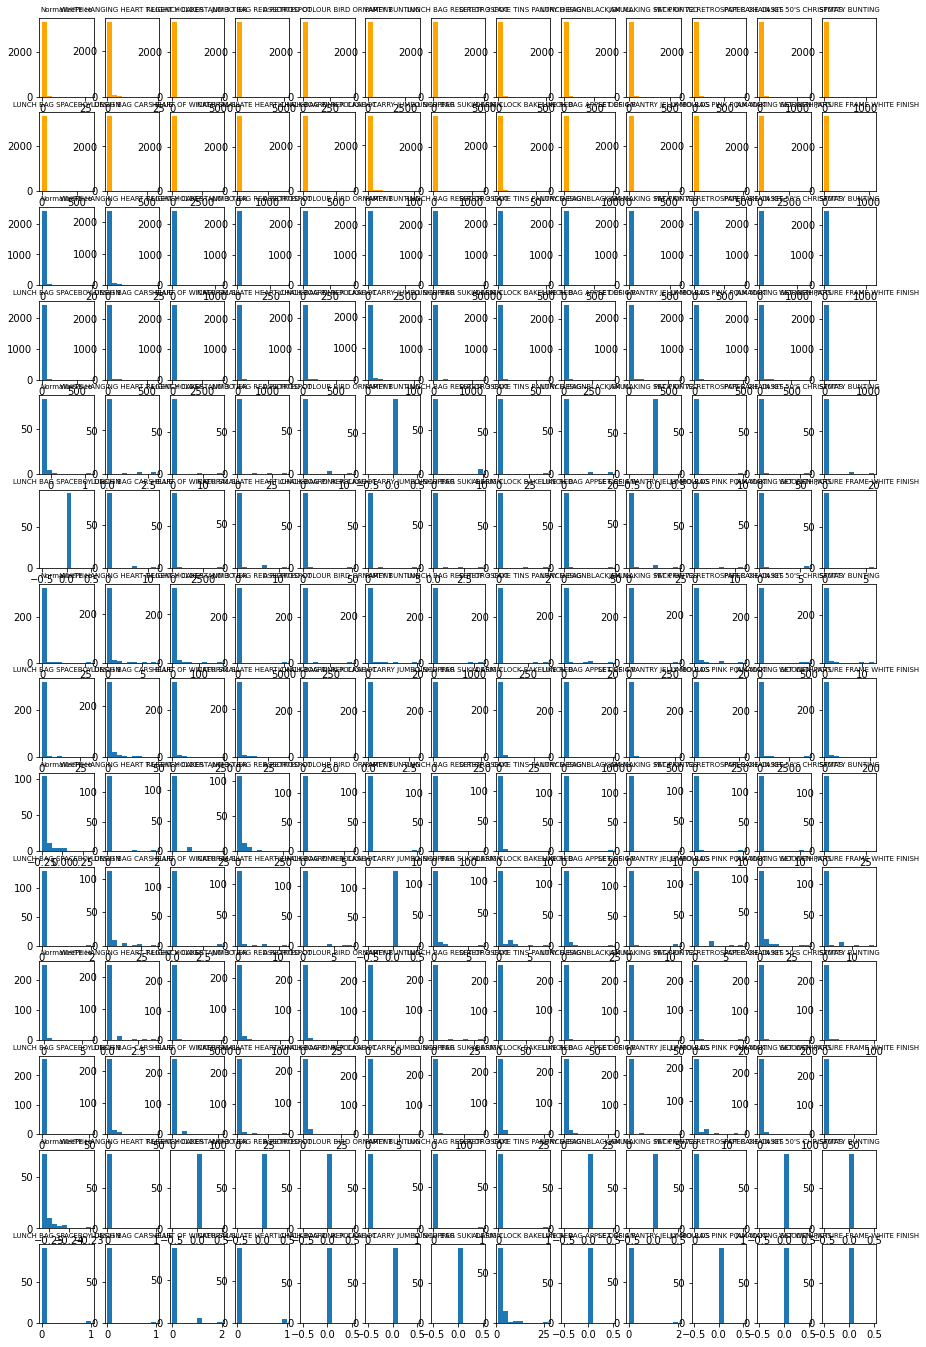

In [103]:
#reprentamos graficamente todas las variables
cols = ['NormalizePrice','WHITE HANGING HEART T-LIGHT HOLDER', 'REGENCY CAKESTAND 3 TIER',
       'JUMBO BAG RED RETROSPOT', 'ASSORTED COLOUR BIRD ORNAMENT',
       'PARTY BUNTING', 'LUNCH BAG RED RETROSPOT',
       'SET OF 3 CAKE TINS PANTRY DESIGN', 'LUNCH BAG  BLACK SKULL.',
       'JAM MAKING SET PRINTED', 'PACK OF 72 RETROSPOT CAKE CASES',
       "PAPER CHAIN KIT 50'S CHRISTMAS", 'SPOTTY BUNTING',
       'LUNCH BAG SPACEBOY DESIGN', 'LUNCH BAG CARS BLUE',
       'HEART OF WICKER SMALL', 'NATURAL SLATE HEART CHALKBOARD',
       'LUNCH BAG PINK POLKADOT', 'REX CASH+CARRY JUMBO SHOPPER',
       'LUNCH BAG SUKI DESIGN', 'ALARM CLOCK BAKELIKE RED',
       'LUNCH BAG APPLE DESIGN', 'SET OF 4 PANTRY JELLY MOULDS',
       'JUMBO BAG PINK POLKADOT', 'JAM MAKING SET WITH JARS',
       'WOODEN PICTURE FRAME WHITE FINISH']
height = len(Final_data_cluster2["cluster"].unique())
plt.figure(figsize=(15,4*height))

for i,col in enumerate(cols):
  plt.subplot(2*(1+height),13,i+1)
  plt.title(col, fontsize='x-small')
  plt.hist(Final_data_cluster2[col],color="orange")

for j,k in enumerate(Final_data_cluster2["cluster"].unique()):
  for i,col in enumerate(cols):
    plt.subplot(2*(1+height),13,(26*(j+1))+i+1)
    plt.title(col, fontsize='x-small')
    plt.hist(Final_data_cluster2[Final_data_cluster2["cluster"]==k][col])
plt.tight_layout();

En la tabla anterior podemos observar una mejor distribución que en la primera

En este segundo caso los clientes están distribuidos de una manera más uniforme entre los clusters pero sigue habiendo clientes muy alejados de los otros.

In [48]:
Final_data_cluster2["cluster"].value_counts()

0    3359
3       9
4       3
5       2
1       1
2       1
Name: cluster, dtype: int64

Representaremos gráficamente los diferentes clusters mediante una reducción de la dimensionalidad para poderlo ver en 2D

In [49]:
#para la representación utilizaremos los centroides
centroides, etiquetas = kmeans.cluster_centers_, kmeans.labels_

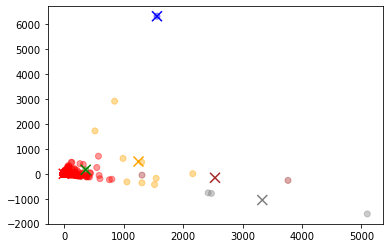

In [50]:
from sklearn.decomposition import PCA
modelo_pca = PCA(n_components=2)
modelo_pca.fit(NormalizePrize_data_total_nmp)
pca = modelo_pca.transform(NormalizePrize_data_total_nmp)

colores=['red','blue','green', 'orange', 'gray','brown']
colores_cluster = [colores[etiquetas[i]] for i in range (len(pca))]

centroides_pca = modelo_pca.transform(centroides)

plt.scatter(pca[:,0], pca[:,1], marker='o', alpha=0.4, c= colores_cluster)
plt.scatter(centroides_pca[:,0], centroides_pca[:,1], marker='x', s=100, linewidths=3, c = colores)


Vamos a predecir en que cluster iran los 5 clientes que eliminamos de la tabla original

In [51]:
Test_data

,PrecioTotal,WHITE HANGING HEART T-LIGHT HOLDER,REGENCY CAKESTAND 3 TIER,JUMBO BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,PARTY BUNTING,LUNCH BAG RED RETROSPOT,SET OF 3 CAKE TINS PANTRY DESIGN,LUNCH BAG BLACK SKULL.,JAM MAKING SET PRINTED,PACK OF 72 RETROSPOT CAKE CASES,PAPER CHAIN KIT 50'S CHRISTMAS,SPOTTY BUNTING,LUNCH BAG SPACEBOY DESIGN,LUNCH BAG CARS BLUE,HEART OF WICKER SMALL,NATURAL SLATE HEART CHALKBOARD,LUNCH BAG PINK POLKADOT,REX CASH+CARRY JUMBO SHOPPER,LUNCH BAG SUKI DESIGN,ALARM CLOCK BAKELIKE RED,LUNCH BAG APPLE DESIGN,SET OF 4 PANTRY JELLY MOULDS,JUMBO BAG PINK POLKADOT,JAM MAKING SET WITH JARS,WOODEN PICTURE FRAME WHITE FINISH
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,
13475.0,141.30,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0
17569.0,54.21,1.0,24.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16464.0,74.49,0.0,0.0,0.0,0.0,2.0,1.0,0.0,2.0,4.0,2.0,2.0,3.0,0.0,0.0,5.0,9.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0
13116.0,35.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0
12515.0,145.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0


Habrá que repetir todos los pasos llevados a cabo con la tabla inicial para que el resultado sea el correcto

In [52]:
NormalizePrize_test_data = pd.DataFrame()
NormalizePrize_test_data['NormalizePrice'] = Test_data.PrecioTotal
NormalizePrize_test_data

,NormalizePrice
CustomerID,
13475.0,141.30
17569.0,54.21
16464.0,74.49
13116.0,35.40
12515.0,145.35


In [53]:
NormalizePrize_test_data_mean = mean_norm(NormalizePrize_test_data)
NormalizePrize_test_data_mean

,NormalizePrice
CustomerID,
13475.0,1.013028
17569.0,-0.711793
16464.0,-0.310147
13116.0,-1.084326
12515.0,1.093238


In [54]:
NormalizePrize_test_data_total = pd.concat([NormalizePrize_test_data_mean,Test_data], axis= 1)
NormalizePrize_test_data_total = NormalizePrize_test_data_total.drop('PrecioTotal', axis=1)
NormalizePrize_test_data_total

,NormalizePrice,WHITE HANGING HEART T-LIGHT HOLDER,REGENCY CAKESTAND 3 TIER,JUMBO BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,PARTY BUNTING,LUNCH BAG RED RETROSPOT,SET OF 3 CAKE TINS PANTRY DESIGN,LUNCH BAG BLACK SKULL.,JAM MAKING SET PRINTED,PACK OF 72 RETROSPOT CAKE CASES,PAPER CHAIN KIT 50'S CHRISTMAS,SPOTTY BUNTING,LUNCH BAG SPACEBOY DESIGN,LUNCH BAG CARS BLUE,HEART OF WICKER SMALL,NATURAL SLATE HEART CHALKBOARD,LUNCH BAG PINK POLKADOT,REX CASH+CARRY JUMBO SHOPPER,LUNCH BAG SUKI DESIGN,ALARM CLOCK BAKELIKE RED,LUNCH BAG APPLE DESIGN,SET OF 4 PANTRY JELLY MOULDS,JUMBO BAG PINK POLKADOT,JAM MAKING SET WITH JARS,WOODEN PICTURE FRAME WHITE FINISH
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,
13475.0,1.013028,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0
17569.0,-0.711793,1.0,24.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16464.0,-0.310147,0.0,0.0,0.0,0.0,2.0,1.0,0.0,2.0,4.0,2.0,2.0,3.0,0.0,0.0,5.0,9.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0
13116.0,-1.084326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0
12515.0,1.093238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0


In [55]:
NormalizePrize_test_data_total_nmp=NormalizePrize_test_data_total.to_numpy()

In [56]:
muestra_prediccion = kmeans2.predict(NormalizePrize_test_data_total_nmp)

In [57]:
for i, pred in enumerate(muestra_prediccion):
  print('el cliente', i, 'pertenece al cluster:', pred)

el cliente 0 pertenece al cluster: 1
el cliente 1 pertenece al cluster: 2
el cliente 2 pertenece al cluster: 1
el cliente 3 pertenece al cluster: 5
el cliente 4 pertenece al cluster: 0


La última opción seria eliminando valores extremos en los datos, que desvirtuan los resultados. En este caso se podría eliminar a los grandes clientes y quedarnos solo con la mayoria que se mantendría cerca de la media, ya sea por arriba o por abajo

In [105]:
Final_data2

,PrecioTotal,WHITE HANGING HEART T-LIGHT HOLDER,REGENCY CAKESTAND 3 TIER,JUMBO BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,PARTY BUNTING,LUNCH BAG RED RETROSPOT,SET OF 3 CAKE TINS PANTRY DESIGN,LUNCH BAG BLACK SKULL.,JAM MAKING SET PRINTED,PACK OF 72 RETROSPOT CAKE CASES,PAPER CHAIN KIT 50'S CHRISTMAS,SPOTTY BUNTING,LUNCH BAG SPACEBOY DESIGN,LUNCH BAG CARS BLUE,HEART OF WICKER SMALL,NATURAL SLATE HEART CHALKBOARD,LUNCH BAG PINK POLKADOT,REX CASH+CARRY JUMBO SHOPPER,LUNCH BAG SUKI DESIGN,ALARM CLOCK BAKELIKE RED,LUNCH BAG APPLE DESIGN,SET OF 4 PANTRY JELLY MOULDS,JUMBO BAG PINK POLKADOT,JAM MAKING SET WITH JARS,WOODEN PICTURE FRAME WHITE FINISH
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,
12347.0,326.25,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0
12348.0,360.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12349.0,353.10,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0
12350.0,40.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12352.0,403.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,5.0,0.0,6.0,12.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18277.0,13.52,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18278.0,15.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18280.0,15.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
Final_dataM = Final_data2.copy()
Final_dataM = Final_dataM.drop(Final_dataM[Final_dataM['PrecioTotal']> 4000].index)
Final_dataM = Final_dataM.drop(Final_dataM[Final_dataM['WHITE HANGING HEART T-LIGHT HOLDER']> 5].index)
Final_dataM = Final_dataM.drop(Final_dataM[Final_dataM['REGENCY CAKESTAND 3 TIER']> 150].index)
Final_dataM = Final_dataM.drop(Final_dataM[Final_dataM['JUMBO BAG RED RETROSPOT']> 40].index)
Final_dataM = Final_dataM.drop(Final_dataM[Final_dataM['ASSORTED COLOUR BIRD ORNAMENT']> 25].index)
Final_dataM = Final_dataM.drop(Final_dataM[Final_dataM['PARTY BUNTING']> 50].index)
Final_dataM = Final_dataM.drop(Final_dataM[Final_dataM['LUNCH BAG RED RETROSPOT']> 100].index)
Final_dataM = Final_dataM.drop(Final_dataM[Final_dataM['SET OF 3 CAKE TINS PANTRY DESIGN']> 25].index)
Final_dataM = Final_dataM.drop(Final_dataM[Final_dataM['PACK OF 72 RETROSPOT CAKE CASES']> 25].index)
Final_dataM = Final_dataM.drop(Final_dataM[Final_dataM['LUNCH BAG APPLE DESIGN']> 25].index)
Final_dataM = Final_dataM.drop(Final_dataM[Final_dataM['SET OF 4 PANTRY JELLY MOULDS']> 35].index)
Final_dataM = Final_dataM.drop(Final_dataM[Final_dataM['JUMBO BAG PINK POLKADOT']> 40].index)
Final_dataM = Final_dataM.drop(Final_dataM[Final_dataM['JAM MAKING SET WITH JARS']> 100].index)
Final_dataM = Final_dataM.drop(Final_dataM[Final_dataM['WOODEN PICTURE FRAME WHITE FINISH']> 25].index)
Final_dataM

,PrecioTotal,WHITE HANGING HEART T-LIGHT HOLDER,REGENCY CAKESTAND 3 TIER,JUMBO BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,PARTY BUNTING,LUNCH BAG RED RETROSPOT,SET OF 3 CAKE TINS PANTRY DESIGN,LUNCH BAG BLACK SKULL.,JAM MAKING SET PRINTED,PACK OF 72 RETROSPOT CAKE CASES,PAPER CHAIN KIT 50'S CHRISTMAS,SPOTTY BUNTING,LUNCH BAG SPACEBOY DESIGN,LUNCH BAG CARS BLUE,HEART OF WICKER SMALL,NATURAL SLATE HEART CHALKBOARD,LUNCH BAG PINK POLKADOT,REX CASH+CARRY JUMBO SHOPPER,LUNCH BAG SUKI DESIGN,ALARM CLOCK BAKELIKE RED,LUNCH BAG APPLE DESIGN,SET OF 4 PANTRY JELLY MOULDS,JUMBO BAG PINK POLKADOT,JAM MAKING SET WITH JARS,WOODEN PICTURE FRAME WHITE FINISH
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,
12347.0,326.25,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0
12348.0,360.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12349.0,353.10,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0
12350.0,40.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12352.0,403.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,5.0,0.0,6.0,12.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18277.0,13.52,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18278.0,15.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18280.0,15.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


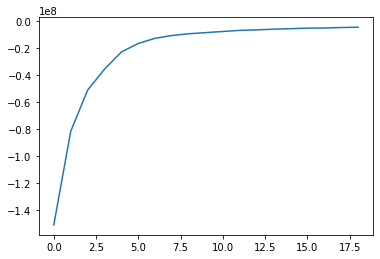

In [108]:
nc = range(1, 20) 
kmeans = [KMeans(n_clusters=i) for i in nc]
score = [kmeans[i].fit(Final_dataM).score(Final_dataM) for i in range(len(kmeans))]

plt.plot(score);

In [109]:
kmeansM = KMeans(n_clusters=4).fit(Final_dataM)

In [110]:
Final_data_clusterM = Final_dataM.copy()
Final_data_clusterM["cluster"] = kmeansM.predict(Final_dataM)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


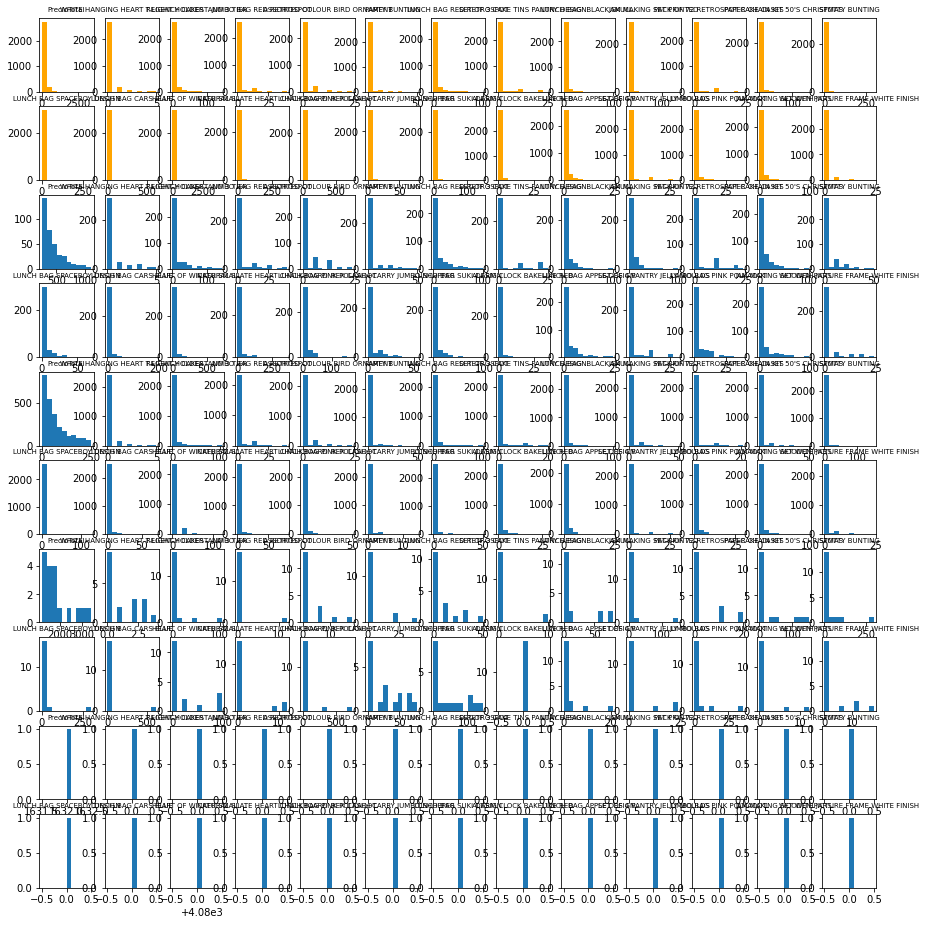

In [112]:
cols = ['PrecioTotal','WHITE HANGING HEART T-LIGHT HOLDER', 'REGENCY CAKESTAND 3 TIER',
       'JUMBO BAG RED RETROSPOT', 'ASSORTED COLOUR BIRD ORNAMENT',
       'PARTY BUNTING', 'LUNCH BAG RED RETROSPOT',
       'SET OF 3 CAKE TINS PANTRY DESIGN', 'LUNCH BAG  BLACK SKULL.',
       'JAM MAKING SET PRINTED', 'PACK OF 72 RETROSPOT CAKE CASES',
       "PAPER CHAIN KIT 50'S CHRISTMAS", 'SPOTTY BUNTING',
       'LUNCH BAG SPACEBOY DESIGN', 'LUNCH BAG CARS BLUE',
       'HEART OF WICKER SMALL', 'NATURAL SLATE HEART CHALKBOARD',
       'LUNCH BAG PINK POLKADOT', 'REX CASH+CARRY JUMBO SHOPPER',
       'LUNCH BAG SUKI DESIGN', 'ALARM CLOCK BAKELIKE RED',
       'LUNCH BAG APPLE DESIGN', 'SET OF 4 PANTRY JELLY MOULDS',
       'JUMBO BAG PINK POLKADOT', 'JAM MAKING SET WITH JARS',
       'WOODEN PICTURE FRAME WHITE FINISH']
height = len(Final_data_clusterM["cluster"].unique())
plt.figure(figsize=(15,4*height))

for i,col in enumerate(cols):
  plt.subplot(2*(1+height),13,i+1)
  plt.title(col, fontsize='x-small')
  plt.hist(Final_data_clusterM[col],color="orange")

for j,k in enumerate(Final_data_clusterM["cluster"].unique()):
  for i,col in enumerate(cols):
    plt.subplot(2*(1+height),13,(26*(j+1))+i+1)
    plt.title(col, fontsize='x-small')
    plt.hist(Final_data_clusterM[Final_data_clusterM["cluster"]==k][col])
plt.tight_layout();

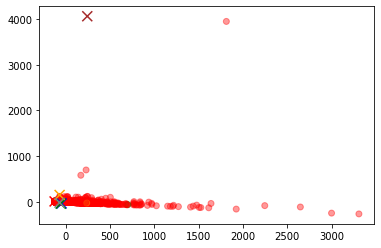

In [120]:
from sklearn.decomposition import PCA
modelo_pca = PCA(n_components=2)
modelo_pca.fit(Final_dataM)
pca = modelo_pca.transform(Final_dataM)

colores=['red','blue','green', 'orange', 'gray','brown']
colores_cluster = [colores[etiquetas[i]] for i in range (len(pca))]

centroides_pca = modelo_pca.transform(centroides)

plt.scatter(pca[:,0], pca[:,1], marker='o', alpha=0.4, c= colores_cluster)
plt.scatter(centroides_pca[:,0], centroides_pca[:,1], marker='x', s=100, linewidths=3, c = colores)


##Reducción de la dimensionalidad PCA

Otra opcón sería reducir la dimensionalidad de la tabla con PCA

In [58]:
Final_data

,PrecioTotal,WHITE HANGING HEART T-LIGHT HOLDER,REGENCY CAKESTAND 3 TIER,JUMBO BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,PARTY BUNTING,LUNCH BAG RED RETROSPOT,SET OF 3 CAKE TINS PANTRY DESIGN,LUNCH BAG BLACK SKULL.,JAM MAKING SET PRINTED,PACK OF 72 RETROSPOT CAKE CASES,PAPER CHAIN KIT 50'S CHRISTMAS,SPOTTY BUNTING,LUNCH BAG SPACEBOY DESIGN,LUNCH BAG CARS BLUE,HEART OF WICKER SMALL,NATURAL SLATE HEART CHALKBOARD,LUNCH BAG PINK POLKADOT,REX CASH+CARRY JUMBO SHOPPER,LUNCH BAG SUKI DESIGN,ALARM CLOCK BAKELIKE RED,LUNCH BAG APPLE DESIGN,SET OF 4 PANTRY JELLY MOULDS,JUMBO BAG PINK POLKADOT,JAM MAKING SET WITH JARS,WOODEN PICTURE FRAME WHITE FINISH
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,
12347.0,326.25,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0
12348.0,360.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12349.0,353.10,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0
12350.0,40.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12352.0,403.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,5.0,0.0,6.0,12.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18277.0,13.52,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18278.0,15.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18280.0,15.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
numeric = Final_data.fillna(Final_data.median())
scaler.fit(numeric) 
X_scaled=scaler.transform(numeric)


/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


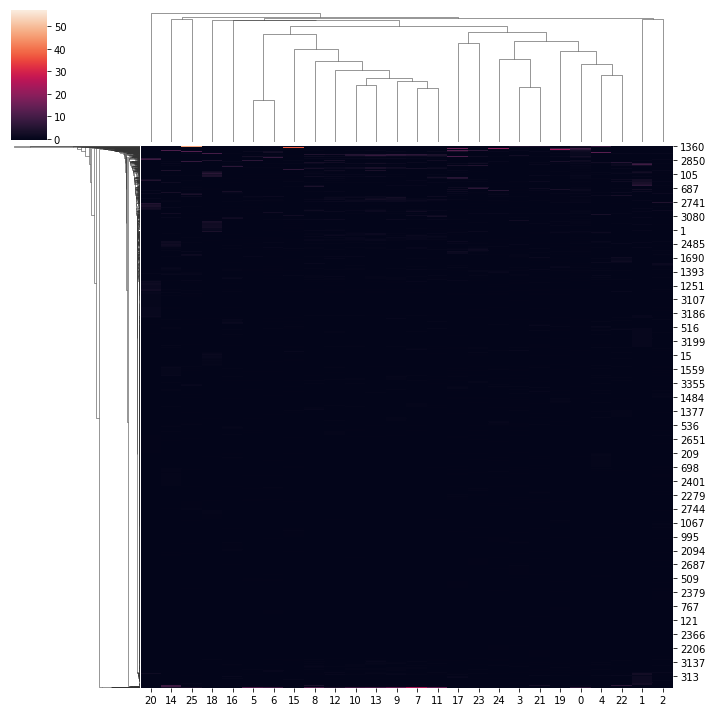

In [60]:
sns.clustermap(X_scaled)

Cogeremos los 9 columnas más importantes de dataset

In [134]:
pca=PCA(n_components=9) 
pca.fit(X_scaled) 
X_pca=pca.transform(X_scaled)

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


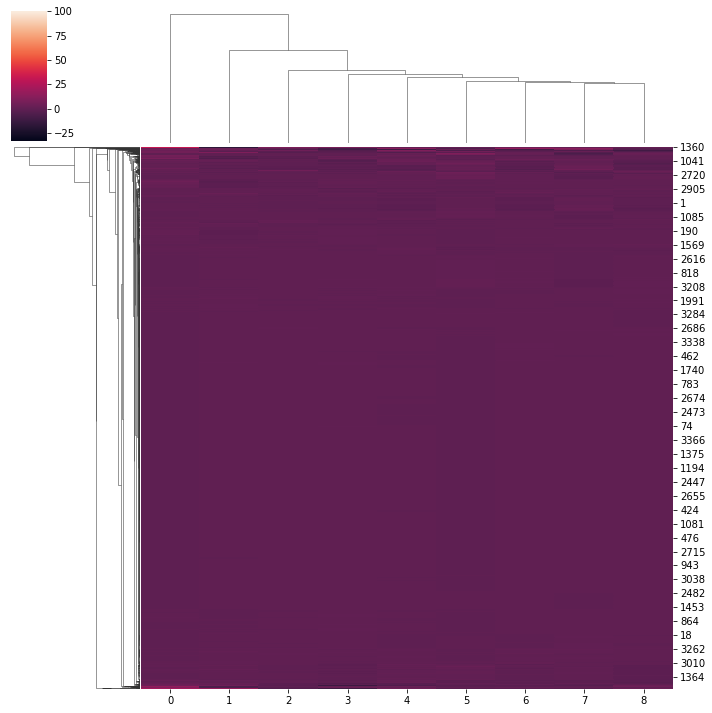

In [135]:
sns.clustermap(X_pca)

In [136]:
expl = pca.explained_variance_ratio_
print(expl)
print('suma:',sum(expl[0:9]))

[0.28580773 0.12941505 0.0659493  0.05653759 0.05036233 0.04057425
 0.04000383 0.03793634 0.03573571]
suma: 0.7423221359573502


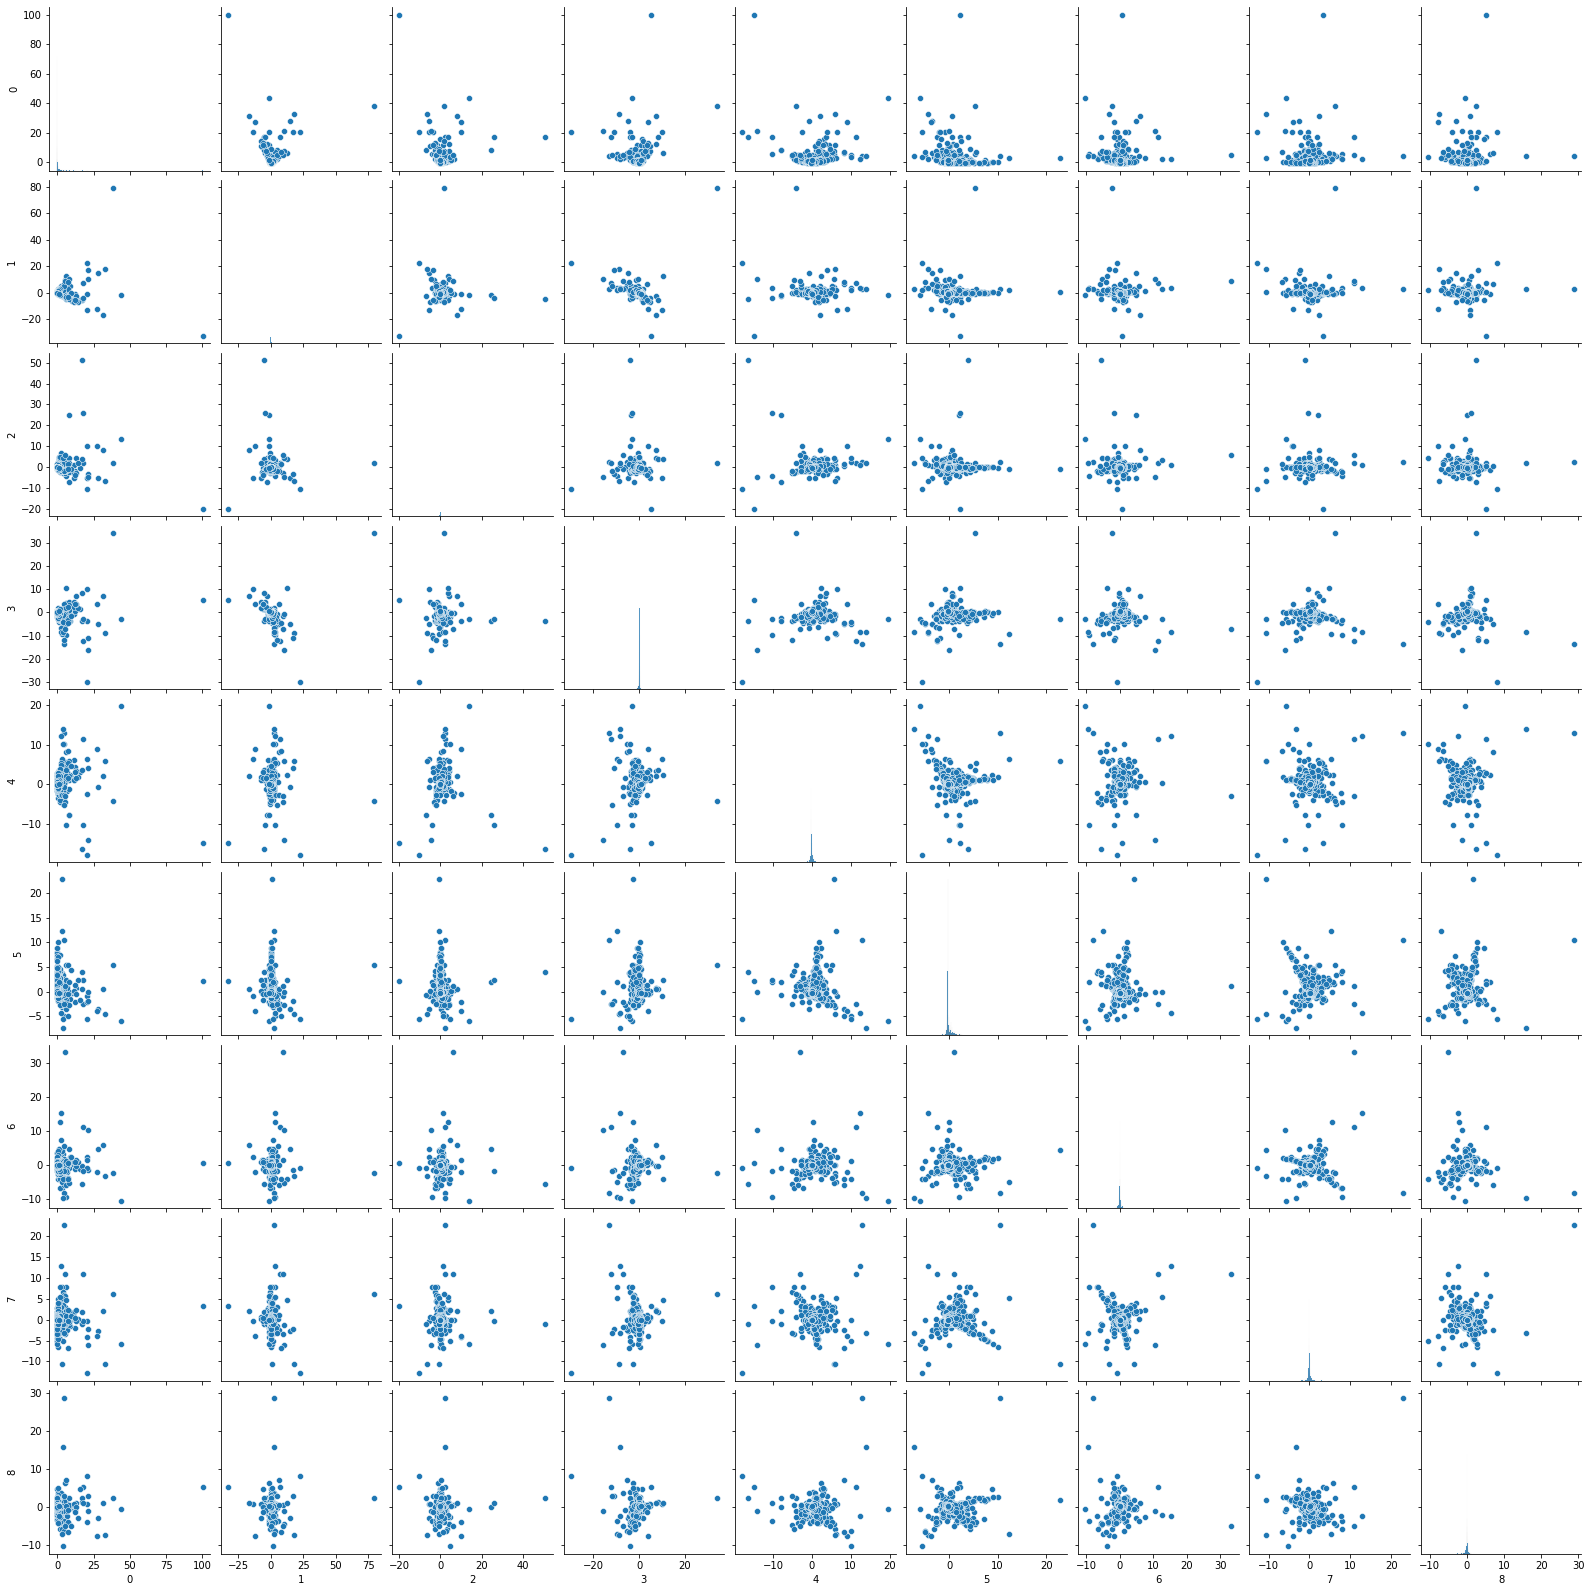

In [137]:
sns.pairplot(pd.DataFrame(X_pca[:,:9]))

Aqui podemos ver que con solo 9 variables podemos explicar el 80% de la varianza

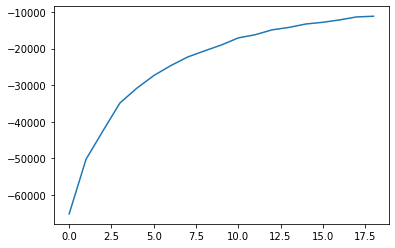

In [138]:
nc = range(1, 20) 
kmeans = [KMeans(n_clusters=i) for i in nc]
score = [kmeans[i].fit(X_pca).score(X_pca) for i in range(len(kmeans))]

plt.plot(score);

In [139]:
kmeans3 = KMeans(n_clusters=6).fit(X_pca)
kmeans3.fit(X_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [92]:
kmeans3.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [140]:
df_seg_kmeans3 = pd.concat([Final_data.reset_index(drop=True), pd.DataFrame(X_pca)], axis=1)
df_seg_kmeans3.columns.values[-9:] = ['Componente1','Componente2','Componente3','Componente4','Componente5','Componente6','Componente7','Componente8','Componente9']
df_seg_kmeans3['SegmentosKmeansPCA']= kmeans3.labels_
df_seg_kmeans3.head()

,PrecioTotal,WHITE HANGING HEART T-LIGHT HOLDER,REGENCY CAKESTAND 3 TIER,JUMBO BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,PARTY BUNTING,LUNCH BAG RED RETROSPOT,SET OF 3 CAKE TINS PANTRY DESIGN,LUNCH BAG BLACK SKULL.,JAM MAKING SET PRINTED,PACK OF 72 RETROSPOT CAKE CASES,PAPER CHAIN KIT 50'S CHRISTMAS,SPOTTY BUNTING,LUNCH BAG SPACEBOY DESIGN,LUNCH BAG CARS BLUE,HEART OF WICKER SMALL,NATURAL SLATE HEART CHALKBOARD,LUNCH BAG PINK POLKADOT,REX CASH+CARRY JUMBO SHOPPER,LUNCH BAG SUKI DESIGN,ALARM CLOCK BAKELIKE RED,LUNCH BAG APPLE DESIGN,SET OF 4 PANTRY JELLY MOULDS,JUMBO BAG PINK POLKADOT,JAM MAKING SET WITH JARS,WOODEN PICTURE FRAME WHITE FINISH,Componente1,Componente2,Componente3,Componente4,Componente5,Componente6,Componente7,Componente8,Componente9,SegmentosKmeansPCA
0,326.25,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.219557,0.199460,-0.318677,-1.214606,0.691730,2.156893,-0.703909,0.500812,-2.113574,0
1,360.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.393975,-0.111440,-0.207087,-0.079547,-0.711282,0.032387,-0.707616,0.822196,-0.380471,0
2,353.10,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,-0.427714,0.128851,-0.043761,0.101487,-0.285594,-0.246846,-0.061658,0.025679,0.044783,0
3,40.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.607347,-0.108886,-0.035978,0.157077,-0.214023,-0.237193,-0.083292,0.049394,0.029901,0
4,403.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,5.0,0.0,6.0,12.0,3.0,0.0,0.0,-0.206418,0.232469,-0.234566,-0.134755,-0.676819,-0.075055,-0.577000,0.493100,-0.262432,0


In [141]:
df_seg_kmeans3.SegmentosKmeansPCA.value_counts()

0    3343
5      26
1       6
3       3
4       1
2       1
Name: SegmentosKmeansPCA, dtype: int64

Graficaremos las dos componentes màs importantes para ver como quedarían nuestros clusters

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


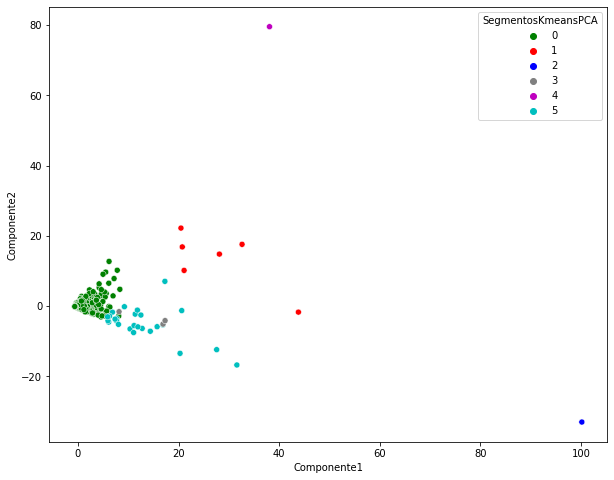

In [142]:
x_axis = df_seg_kmeans3['Componente1']
y_axis = df_seg_kmeans3['Componente2']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis, y_axis, hue=df_seg_kmeans3['SegmentosKmeansPCA'], palette=['green', 'red', 'blue', 'grey', 'm', 'c'])
plt.show()

##Conclusiones

###Modelos sin PCA

Primero vamos a compar los clusteres de los modelos analizados sin PCA

In [115]:
#creamos un dataframe con los número de cliente por cluster
x1 = pd.DataFrame()
x1['clusters'] = Final_data_cluster["cluster"].value_counts()
x1['index']=x1.index
x2 = pd.DataFrame()
x2['clusters'] = Final_data_cluster2["cluster"].value_counts()
x2['index']=x2.index
x1

,clusters,index
0,2472,0
5,330,5
2,259,2
3,130,3
4,93,4
1,91,1


Text(0.5, 1.0, 'Clientes/cluster')

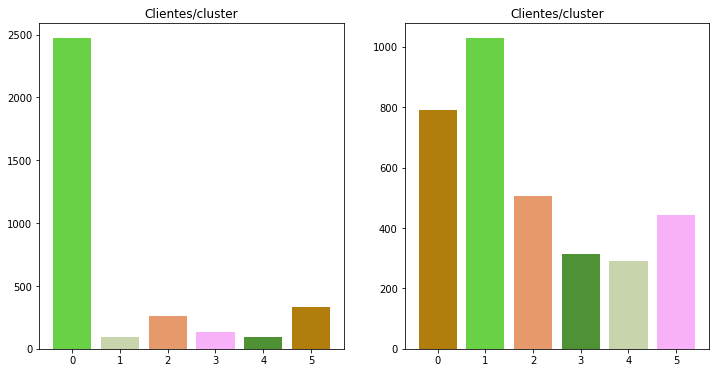

In [116]:
#representamos gráficamente los valores anteriores
f = plt.figure()
f.set_size_inches(12,6)
ax = f.add_subplot(1, 2, 1)
from random import randint
colors = []

for i in range(6):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

ax.bar(x1.iloc[:,1], x1.iloc[:,0], color=colors)
ax.set_title('Clientes/cluster')
ax = f.add_subplot(1, 2, 2)
ax.bar(x2.iloc[:,1], x2.iloc[:,0], color=colors)
ax.set_title('Clientes/cluster')

En las tablas anteriores pordemos ver que, en la primera, un unico cluster agrupa a practicamente todos los clientes, mientras que en la segunda, aun habiendo un cluster mucho más grande que el otro, la distribución es más homogénea.

esto nos lleva a tomar la decisión de que el segundo modelo es mejor que el primero, aunque habría que entender el modelo de negocio que se quiere implementar ya que en el segundo caso queda muy reducido el peso del dinero gastado por los clientes

###Modelo con PCA

el modelo con PCA nos reduce la dimensionalidad de los datos iniciales y nos permite clasificar a los clientes siguiendo unas nuevas categorias generadas por el modelo. 
Esto nos permite reducir la contaminación en los resultados pero en el caso que tratamos hace más complicado relacionar a un cliente en concreto con un objeto en concreto

## Hierarchical clustering

Vamos a probar con un segundo método de agrupación jerarquica.

Este método tiene la ventaja de que no vamos a necesitar elegir previamente el número de cluster que queremos.

Para continuar con la lógica anterior y poder compara los resultado, utilizaremos la tabla con el PrecioTotal normalizado

In [117]:
Final_dataM.head()

,PrecioTotal,WHITE HANGING HEART T-LIGHT HOLDER,REGENCY CAKESTAND 3 TIER,JUMBO BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,PARTY BUNTING,LUNCH BAG RED RETROSPOT,SET OF 3 CAKE TINS PANTRY DESIGN,LUNCH BAG BLACK SKULL.,JAM MAKING SET PRINTED,PACK OF 72 RETROSPOT CAKE CASES,PAPER CHAIN KIT 50'S CHRISTMAS,SPOTTY BUNTING,LUNCH BAG SPACEBOY DESIGN,LUNCH BAG CARS BLUE,HEART OF WICKER SMALL,NATURAL SLATE HEART CHALKBOARD,LUNCH BAG PINK POLKADOT,REX CASH+CARRY JUMBO SHOPPER,LUNCH BAG SUKI DESIGN,ALARM CLOCK BAKELIKE RED,LUNCH BAG APPLE DESIGN,SET OF 4 PANTRY JELLY MOULDS,JUMBO BAG PINK POLKADOT,JAM MAKING SET WITH JARS,WOODEN PICTURE FRAME WHITE FINISH
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,
12347.0,326.25,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0
12348.0,360.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12349.0,353.10,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0
12350.0,40.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12352.0,403.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,5.0,0.0,6.0,12.0,3.0,0.0,0.0


In [118]:
from sklearn.cluster import AgglomerativeClustering

clusteringHC = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

resultHC = clusteringHC.fit_predict(Final_dataM)

resultHC

array([2763, 2977, 1492, ...,    4,    1,    0])

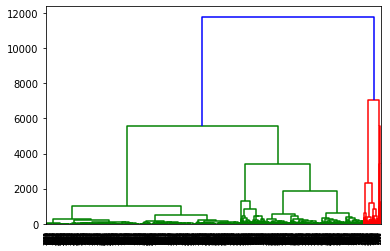

In [119]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris


def plot_dendrogram(model, **kwargs):
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    
    dendrogram(linkage_matrix, **kwargs)
    
plot_dendrogram(clusteringHC)

Si cogemos la barra vertical màs alta sin contar, vemos que se tendrían que elegir 3 clusters para crear nuestros grupos

In [77]:
df_seg_kmeans3.columns.values

array(['PrecioTotal', 'WHITE HANGING HEART T-LIGHT HOLDER',
       'REGENCY CAKESTAND 3 TIER', 'JUMBO BAG RED RETROSPOT',
       'ASSORTED COLOUR BIRD ORNAMENT', 'PARTY BUNTING',
       'LUNCH BAG RED RETROSPOT', 'SET OF 3 CAKE TINS PANTRY DESIGN',
       'LUNCH BAG  BLACK SKULL.', 'JAM MAKING SET PRINTED',
       'PACK OF 72 RETROSPOT CAKE CASES',
       "PAPER CHAIN KIT 50'S CHRISTMAS", 'SPOTTY BUNTING',
       'LUNCH BAG SPACEBOY DESIGN', 'LUNCH BAG CARS BLUE',
       'HEART OF WICKER SMALL', 'NATURAL SLATE HEART CHALKBOARD',
       'LUNCH BAG PINK POLKADOT', 'REX CASH+CARRY JUMBO SHOPPER',
       'LUNCH BAG SUKI DESIGN', 'ALARM CLOCK BAKELIKE RED',
       'LUNCH BAG APPLE DESIGN', 'SET OF 4 PANTRY JELLY MOULDS',
       'JUMBO BAG PINK POLKADOT', 'JAM MAKING SET WITH JARS',
       'WOODEN PICTURE FRAME WHITE FINISH', 'Componente1', 'Componente2',
       'Componente3', 'Componente4', 'Componente5', 'Componente6',
       'Componente7', 'Componente8', 'Componente9', 'SegmentosKmeansPCA

In [78]:
df_seg_HC = df_seg_kmeans3.copy().drop(['PrecioTotal', 'WHITE HANGING HEART T-LIGHT HOLDER',
       'REGENCY CAKESTAND 3 TIER', 'JUMBO BAG RED RETROSPOT',
       'ASSORTED COLOUR BIRD ORNAMENT', 'PARTY BUNTING',
       'LUNCH BAG RED RETROSPOT', 'SET OF 3 CAKE TINS PANTRY DESIGN',
       'LUNCH BAG  BLACK SKULL.', 'JAM MAKING SET PRINTED',
       'PACK OF 72 RETROSPOT CAKE CASES',
       "PAPER CHAIN KIT 50'S CHRISTMAS", 'SPOTTY BUNTING',
       'LUNCH BAG SPACEBOY DESIGN', 'LUNCH BAG CARS BLUE',
       'HEART OF WICKER SMALL', 'NATURAL SLATE HEART CHALKBOARD',
       'LUNCH BAG PINK POLKADOT', 'REX CASH+CARRY JUMBO SHOPPER',
       'LUNCH BAG SUKI DESIGN', 'ALARM CLOCK BAKELIKE RED',
       'LUNCH BAG APPLE DESIGN', 'SET OF 4 PANTRY JELLY MOULDS',
       'JUMBO BAG PINK POLKADOT', 'JAM MAKING SET WITH JARS',
       'WOODEN PICTURE FRAME WHITE FINISH', 'SegmentosKmeansPCA'], axis=1)
df_seg_HC

,Componente1,Componente2,Componente3,Componente4,Componente5,Componente6,Componente7,Componente8,Componente9
0,-0.219557,0.199460,-0.318663,-1.214585,0.691719,2.156859,-0.703727,0.500804,-2.113471
1,-0.393975,-0.111440,-0.207083,-0.079546,-0.711289,0.032421,-0.707647,0.822227,-0.380416
2,-0.427714,0.128851,-0.043748,0.101493,-0.285593,-0.246931,-0.061650,0.025732,0.044502
3,-0.607347,-0.108886,-0.035979,0.157074,-0.214020,-0.237186,-0.083302,0.049398,0.029864
4,-0.206418,0.232469,-0.234592,-0.134777,-0.676815,-0.074861,-0.577015,0.493054,-0.262137
...,...,...,...,...,...,...,...,...,...
3375,-0.625559,-0.103463,-0.010431,0.165006,-0.131179,-0.253891,-0.018211,-0.010945,0.126840
3376,-0.577517,-0.070174,-0.070084,-0.042802,0.037831,0.223024,-0.136378,0.074234,-0.370267
3377,-0.577517,-0.070174,-0.070084,-0.042802,0.037831,0.223024,-0.136378,0.074234,-0.370267
3378,-0.618590,-0.094706,-0.019381,0.153443,-0.165659,-0.276689,-0.010356,-0.055689,0.089066


In [79]:
clusteringdf_segHC = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

resultdf_segHC = clusteringdf_segHC.fit_predict(df_seg_HC)

resultdf_segHC

array([2139, 3379, 3313, ...,    4,    1,    0])

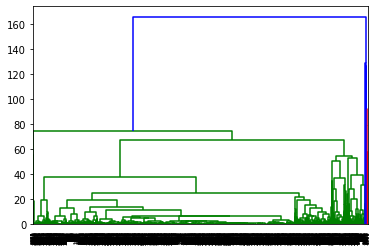

In [80]:
plot_dendrogram(clusteringdf_segHC)

En este caso el dendograma resultante es, nos llevaria a elegir 5 clusters para entrenar nuestro modelo

##DBSCAN

DBSCAN es un algoritmo de agrupamiento basado en la densidad de puntos. Comienza en un punto al azar y cuenta todos los puntos que estan dentro de un radio dado. Si el número de puntos es superior a un número predeterminado considera que esos puntos pertenecen al mismo cluster, Progresivamente el centro de la circunferencia se va moviendo de punto a punto hasta que todos los puntos han sido metidos en un cluster o se han considerado ruido si el número de puntos vecinos era inferior al número predeterminado

Siguiendo lo anterior, necesitaremos establecer tanto el radio elegido como el número mínimo de objetos.

 0    2471
-1     770
 1     112
 2      27
dtype: int64

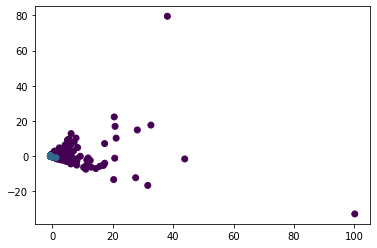

In [81]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=.40, min_samples=10)

clusters = dbscan.fit_predict(df_seg_HC)

plt.scatter(df_seg_HC['Componente1'], df_seg_HC['Componente2'], c = clusters)
pd.Series(clusters).value_counts()

 0    2891
-1     452
 1      26
 2      11
dtype: int64

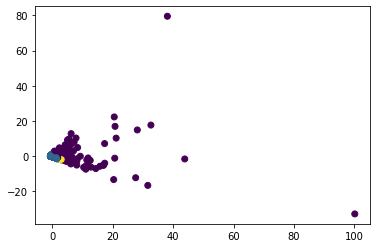

In [145]:
dbscan = DBSCAN(eps=.70, min_samples=10)

clusters = dbscan.fit_predict(df_seg_HC)

plt.scatter(df_seg_HC['Componente1'], df_seg_HC['Componente2'], c = clusters)
pd.Series(clusters).value_counts()

## Conclusiones

Como se ha desmostrado en los otros modelos, la mayoria de los datos son muy parecidos, esto nos lleva a que practicamente todos los clientes se pueden meter en un cluster

## Indice silhouette

In [155]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [146]:
Final_dataM.head()

,PrecioTotal,WHITE HANGING HEART T-LIGHT HOLDER,REGENCY CAKESTAND 3 TIER,JUMBO BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,PARTY BUNTING,LUNCH BAG RED RETROSPOT,SET OF 3 CAKE TINS PANTRY DESIGN,LUNCH BAG BLACK SKULL.,JAM MAKING SET PRINTED,PACK OF 72 RETROSPOT CAKE CASES,PAPER CHAIN KIT 50'S CHRISTMAS,SPOTTY BUNTING,LUNCH BAG SPACEBOY DESIGN,LUNCH BAG CARS BLUE,HEART OF WICKER SMALL,NATURAL SLATE HEART CHALKBOARD,LUNCH BAG PINK POLKADOT,REX CASH+CARRY JUMBO SHOPPER,LUNCH BAG SUKI DESIGN,ALARM CLOCK BAKELIKE RED,LUNCH BAG APPLE DESIGN,SET OF 4 PANTRY JELLY MOULDS,JUMBO BAG PINK POLKADOT,JAM MAKING SET WITH JARS,WOODEN PICTURE FRAME WHITE FINISH
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,
12347.0,326.25,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0
12348.0,360.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12349.0,353.10,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0
12350.0,40.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12352.0,403.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,5.0,0.0,6.0,12.0,3.0,0.0,0.0


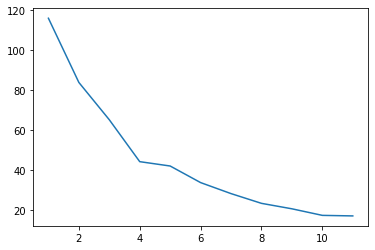

In [147]:
from scipy.spatial.distance import cdist
#data = NormalizePrize_data_total[['NormalizePrice','WHITE HANGING HEART T-LIGHT HOLDER']]
data = Final_dataM[['PrecioTotal','WHITE HANGING HEART T-LIGHT HOLDER']]
max_clusters = 12

clusteringsSH = []
scoresSH = []

for n_clusters in range(1, max_clusters):
    
    kmeansSH = KMeans(n_clusters)
    clustersSH= kmeansSH.fit_predict(data)
    
    distances = cdist(data, kmeansSH.cluster_centers_)
    score = np.mean(np.min(distances, axis=1))
    
    scoresSH.append(score)
    clusteringsSH.append(clustersSH)
    
plt.plot(range(1, max_clusters), scoresSH)

<BarContainer object of 10 artists>

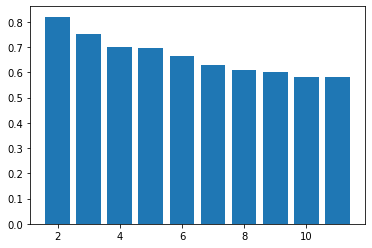

In [148]:
from sklearn.metrics import silhouette_score

silhouettes = []

for clustering in clusteringsSH[1:]:
    silhouettes.append(silhouette_score(data, clustering))
    
plt.bar(range(2, max_clusters), silhouettes)

Con un valor tan alto significa que hay una relación estrecha entre ambas columnas

In [154]:
kmeansM = KMeans(n_clusters=4).fit(Final_dataM)
Final_data_clusterM = Final_dataM.copy()
Final_data_clusterM["cluster"] = kmeansM.predict(Final_dataM)

(3380, 26)

In [172]:
df_seg_kmeans5 = pd.DataFrame() 
df_seg_kmeans5 = df_seg_kmeans3[['Componente1','Componente2','Componente3','Componente4','Componente5','Componente6','Componente7','Componente8','Componente9']]
df_seg_kmeans5

,Componente1,Componente2,Componente3,Componente4,Componente5,Componente6,Componente7,Componente8,Componente9
0,-0.219557,0.199460,-0.318677,-1.214606,0.691730,2.156893,-0.703909,0.500812,-2.113574
1,-0.393975,-0.111440,-0.207087,-0.079547,-0.711282,0.032387,-0.707616,0.822196,-0.380471
2,-0.427714,0.128851,-0.043761,0.101487,-0.285594,-0.246846,-0.061658,0.025679,0.044783
3,-0.607347,-0.108886,-0.035978,0.157077,-0.214023,-0.237193,-0.083292,0.049394,0.029901
4,-0.206418,0.232469,-0.234566,-0.134755,-0.676819,-0.075055,-0.577000,0.493100,-0.262432
...,...,...,...,...,...,...,...,...,...
3375,-0.625559,-0.103463,-0.010430,0.165009,-0.131182,-0.253894,-0.018204,-0.010946,0.126892
3376,-0.577517,-0.070174,-0.070083,-0.042800,0.037829,0.223012,-0.136413,0.074238,-0.370266
3377,-0.577517,-0.070174,-0.070083,-0.042800,0.037829,0.223012,-0.136413,0.074238,-0.370266
3378,-0.618590,-0.094706,-0.019381,0.153444,-0.165662,-0.276682,-0.010346,-0.055691,0.089125


For n_clusters = 2 The average silhouette_score is : 0.9508214209477289
For n_clusters = 3 The average silhouette_score is : 0.9461694603606662
For n_clusters = 4 The average silhouette_score is : 0.9334822520434959
For n_clusters = 5 The average silhouette_score is : 0.9137154530772523
For n_clusters = 6 The average silhouette_score is : 0.8549108381752967


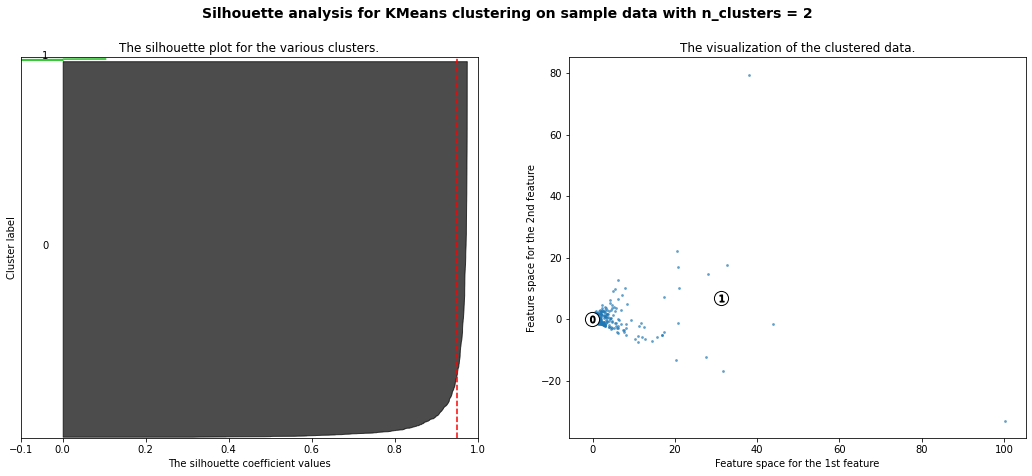

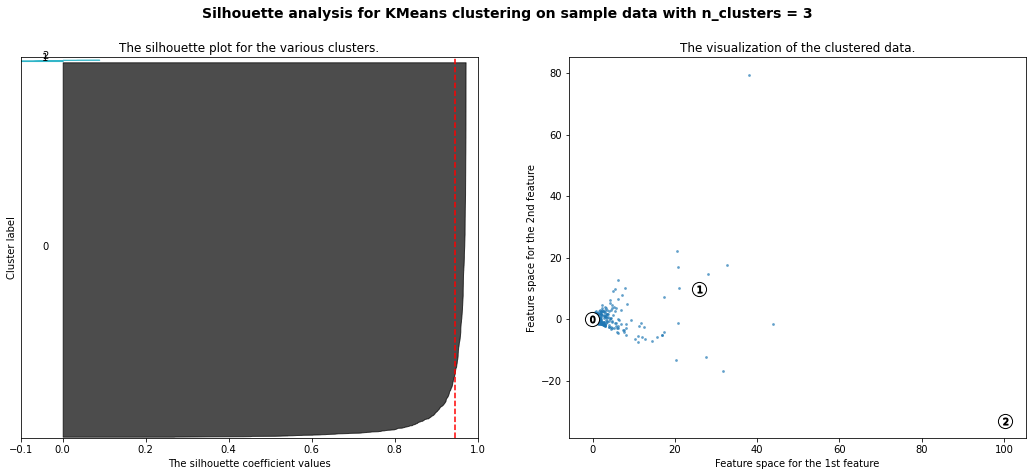

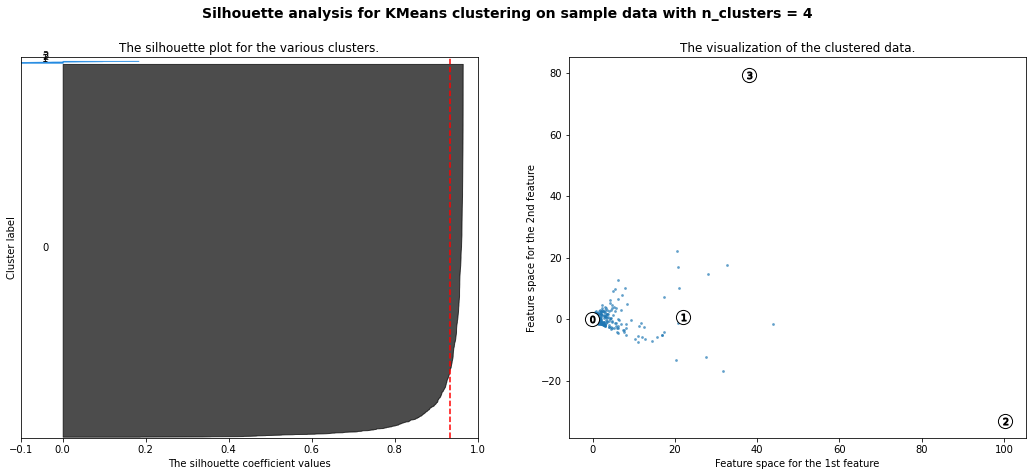

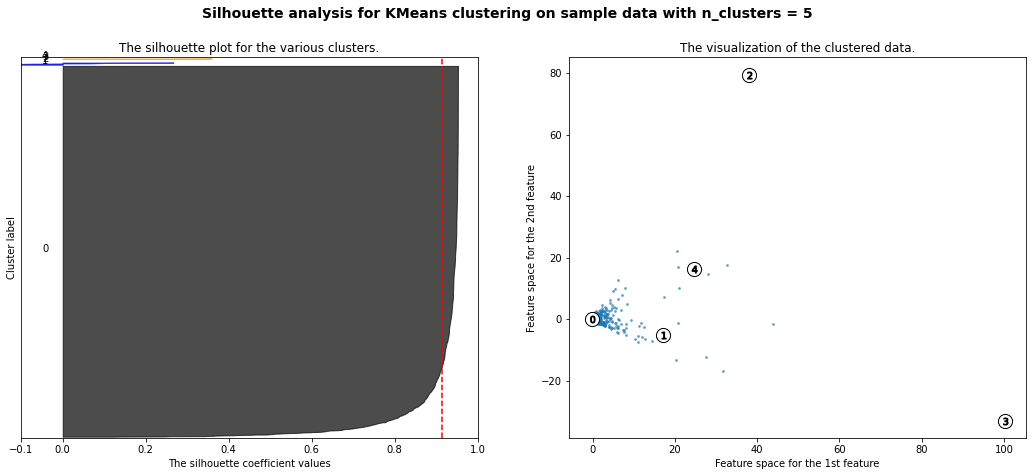

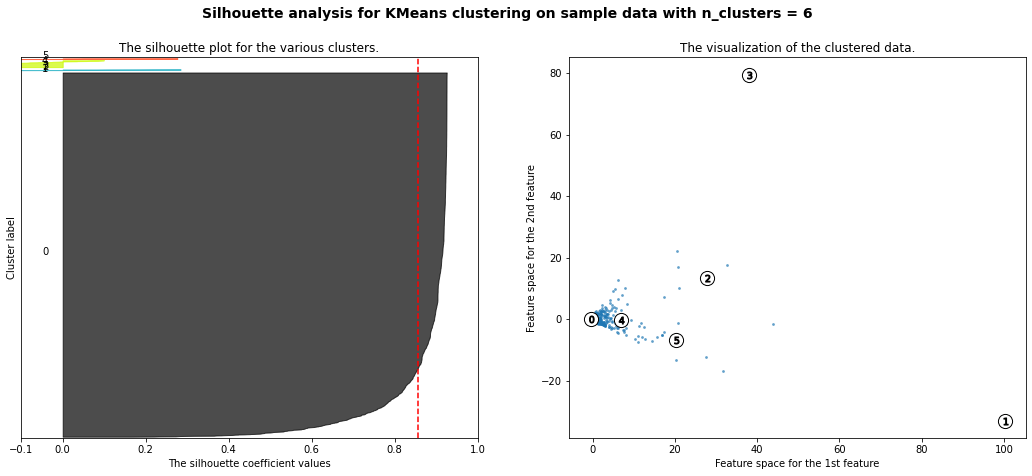

In [173]:
range_n_clusters = [2, 3, 4, 5, 6]
X = df_seg_kmeans5.to_numpy()
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7)
                #c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

#Conclusiones finales

- Al seleccionar solo los 25 elementos más frecuentes la cantidad de datos analizada no es suficiente para llevar a cabo los modelos de forma óptima

- Los datos estan por lo general muy desvalanceados


- Al reducir la dimensionalidad podemos observar que con 2 variables agrupariamos al 60% de los clientes y con 9 cerca de 90%


- El tener tan pocas variables independientes, y ciertamente parecidas entre ellas, no lleva a que los modelos tiendan a hacer un solo cluster o un número muy alto de los mismos